In [1]:
import pandas as pd
import sqlite3
import emoji
from collections import Counter
from pprint import pprint

from matplotlib.pyplot import yscale, xscale, title, plot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import jieba
import re
from collections import Counter
import jieba.analyse

In [2]:
def read_sql():
    df = __read_sql()
    df = __select_taipei_area(df)
    df = __clean_raw_dataframe(df)
    return df

# read raw data from sql
def __read_sql():
    con = sqlite3.connect('../data/InstagramPost.sqlite')
    con2 = sqlite3.connect('../data/InstagramPost2.sqlite')
    con3 = sqlite3.connect('../data/InstagramPost3.sqlite')
    SQL = pd.read_sql_query('select * from InstagramPost', con)
    SQL2 = pd.read_sql_query('select * from InstagramPost_table2', con)
    SQL3 = pd.read_sql_query('select * from InstagramPost_table3', con)
    SQL4 = pd.read_sql_query('select * from InstagramPost_table4', con)
    SQL5 = pd.read_sql_query('select * from InstagramPost_table2', con2)
    SQL6 = pd.read_sql_query('select * from InstagramPost', con3)

    # concat SQL tables
    SQL = pd.concat([SQL, SQL2, SQL3, SQL4, SQL5, SQL6]).drop_duplicates()
    del SQL2, SQL3, SQL4, SQL5, SQL6
    SQL['datetime'] = pd.to_datetime(SQL.date, unit='s')
    instagram2016 = SQL[SQL.datetime.dt.year == 2016]
    del SQL
    return instagram2016

# select taipei area
def __select_taipei_area(df):
#     # 基隆路附近
#     lat_min = 25.032840
#     lat_max = 25.051496
#     lng_min = 121.557441
#     lng_max = 121.580229
    
    # 台北市
    lat_min, lng_min = 24.975456, 121.461888
    lat_max, lng_max = 25.100281, 121.611286

    df['lat'] = df.lat.astype(float)
    df['lng'] = df.lng.astype(float)

    lat_bound = df.lat.between(lat_min, lat_max)
    lng_bound = df.lng.between(lng_min, lng_max)
    df = df[lat_bound & lng_bound]
    return df

# clean datafrome
def __clean_raw_dataframe(df):
    df = df[['location_id', 'location_name', 'lat', 'lng', 'caption', 'comments',
             'date', 'media_id', 'is_video', 'likes', 'owner_id', 'thumbnail_src',
             'display_src', 'datetime']].reset_index().drop(columns='index')
    return df

# 1. Load Data

In [3]:
ig2016 = read_sql()

In [4]:
ig2016.dtypes

location_id              object
location_name            object
lat                     float64
lng                     float64
caption                  object
comments                  int64
date                      int64
media_id                 object
is_video                  int64
likes                     int64
owner_id                  int64
thumbnail_src            object
display_src              object
datetime         datetime64[ns]
dtype: object

In [5]:
ig2016.head(2)

,location_id,location_name,lat,lng,caption,comments,date,media_id,is_video,likes,owner_id,thumbnail_src,display_src,datetime
0,539785069465598,駱馬休息站,25.060489,121.558019,-\n「駱馬」\n哺乳綱 偶蹄目 駱駝科 \n駱馬又名無峰駱駝，是群居的動物，非常耐旱，牠的...,15,1477227676,1367407320455448673,0,77,472063179,https://instagram.ftpe7-4.fna.fbcdn.net/t51.28...,https://instagram.ftpe7-4.fna.fbcdn.net/t51.28...,2016-10-23 13:01:16
1,1030274404,珍妮姐姐,25.033070,121.574303,4y9m31d\n🎃🎃🎃萬聖節不搗蛋要幹嘛.....來當小小波麗士啦！🚔🚔🚔一個好老成的交警...,0,1477722698,1371559858339338657,0,10,471686179,https://instagram.ftpe7-4.fna.fbcdn.net/t51.28...,https://instagram.ftpe7-4.fna.fbcdn.net/t51.28...,2016-10-29 06:31:38


# 2. Preview overall info

In [107]:
def chart_preset(color):
    plt.figure(figsize=[10, 2], edgecolor=color)
    plt.axis('off')

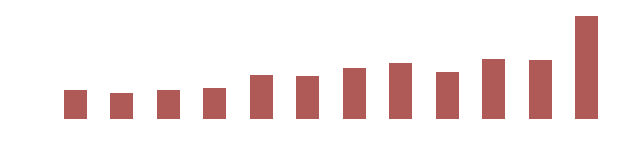

In [108]:
color = '#000000'
chart_preset(color)
(ig2016['datetime'].dt
    .month
    .value_counts()
    .sort_index()).plot.bar(color='#b05a57')
plt.savefig('./plot/plot.png', transparent=True)

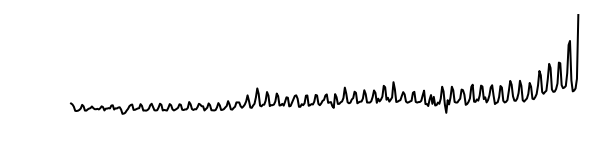

In [126]:
color = '#000000'
chart_preset(color)
(ig2016['datetime'].dt
    .date
    .value_counts()
    .sort_index()).plot.line(color=color, linewidth=2)
# plt.savefig('./plot/plot.png', 
#             transparent=True, 
#             bbox_inches='tight',
#             pad_inches=0)

In [139]:
def get_loc_info(loc, df):
    locGroup = df.groupby('location_name')
    oneGroup = locGroup.get_group(loc).reset_index().drop('index', 1)
    oneGroup['date'] = oneGroup.datetime.dt.date
    oneGroup['month'] = oneGroup.datetime.dt.month
    loc_name = oneGroup['location_name'][0]
     
    print('\n', 'Location:', loc,
         '\n', 'Data Length:', len(oneGroup),
         '\n', 'Name: ', loc_name)
    print(oneGroup.describe())
    return oneGroup

def get_loc_plot(loc, df, fname):
    COLOR = '#FFFFFF'
    plt.figure(figsize=(20, 4))
    plt.axis('off')
    oneGroup = get_loc_info(loc, df).set_index('datetime')
    loc_name = oneGroup['location_name'][0]
    loc_name = oneGroup['location_name'][0]
    ax2 = oneGroup.date.value_counts().sort_index().plot.line(color=COLOR)
    plt.savefig('./plot/{0}.png'.format(fname), transparent=True)
    plt.show()



 Location: TAIPEI 101 MALL 台北 101 購物中心 
 Data Length: 31126 
 Name:  TAIPEI 101 MALL 台北 101 購物中心
                lat           lng      comments      is_video         likes  \
count  3.112600e+04  3.112600e+04  31126.000000  31126.000000  31126.000000   
mean   2.503392e+01  1.215645e+02      1.804569      0.066440     54.993317   
std    1.296051e-11  5.999919e-11      3.881747      0.249053    458.122482   
min    2.503392e+01  1.215645e+02      0.000000      0.000000      0.000000   
25%    2.503392e+01  1.215645e+02      0.000000      0.000000      9.000000   
50%    2.503392e+01  1.215645e+02      0.000000      0.000000     20.000000   
75%    2.503392e+01  1.215645e+02      2.000000      0.000000     43.000000   
max    2.503392e+01  1.215645e+02    200.000000      1.000000  58691.000000   

           owner_id         month  
count  3.112600e+04  31126.000000  
mean   1.016463e+09      9.970121  
std    1.071101e+09      2.338944  
min    8.770000e+02      1.000000  
25%    2.1

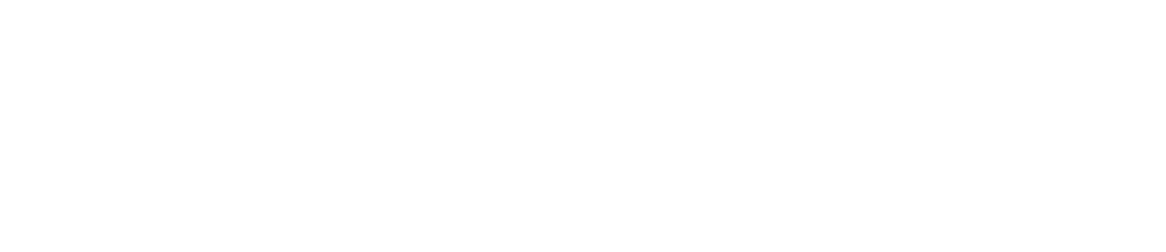


 Location: BELLAVITA 
 Data Length: 24917 
 Name:  BELLAVITA
                lat           lng      comments      is_video         likes  \
count  2.491700e+04  2.491700e+04  24917.000000  24917.000000  24917.000000   
mean   2.503972e+01  1.215674e+02      2.529679      0.023077     84.520408   
std    8.263778e-12  3.240140e-12      4.262240      0.150150    618.217960   
min    2.503972e+01  1.215674e+02      0.000000      0.000000      0.000000   
25%    2.503972e+01  1.215674e+02      0.000000      0.000000     16.000000   
50%    2.503972e+01  1.215674e+02      1.000000      0.000000     36.000000   
75%    2.503972e+01  1.215674e+02      4.000000      0.000000     72.000000   
max    2.503972e+01  1.215674e+02    224.000000      1.000000  66042.000000   

           owner_id         month  
count  2.491700e+04  24917.000000  
mean   7.747128e+08     10.782799  
std    8.568978e+08      2.538296  
min    5.756000e+03      1.000000  
25%    2.404757e+08     11.000000  
50%    4.1

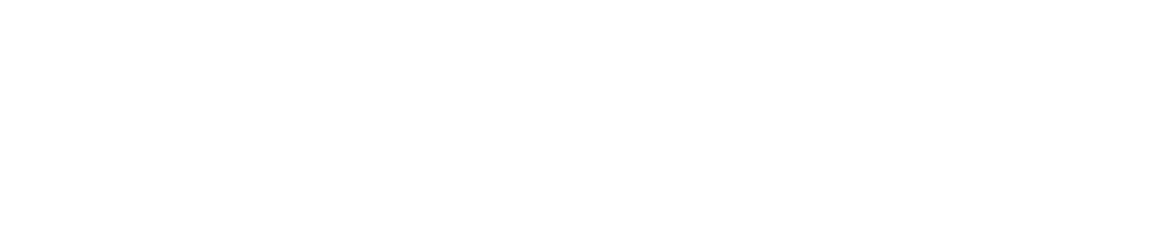


 Location: 松山文創園區 SCCP Taipei 
 Data Length: 22906 
 Name:  松山文創園區 SCCP Taipei
                lat           lng     comments      is_video         likes  \
count  2.290600e+04  2.290600e+04  22906.00000  22906.000000  22906.000000   
mean   2.504406e+01  1.215578e+02      1.70344      0.054091     58.906924   
std    3.609636e-12  4.867324e-11      3.40279      0.226201    485.734131   
min    2.504406e+01  1.215578e+02      0.00000      0.000000      0.000000   
25%    2.504406e+01  1.215578e+02      0.00000      0.000000      7.000000   
50%    2.504406e+01  1.215578e+02      0.00000      0.000000     19.000000   
75%    2.504406e+01  1.215578e+02      2.00000      0.000000     43.000000   
max    2.504406e+01  1.215578e+02    146.00000      1.000000  42569.000000   

           owner_id         month  
count  2.290600e+04  22906.000000  
mean   8.452906e+08      8.011525  
std    9.251089e+08      2.950031  
min    1.167000e+03      1.000000  
25%    2.091395e+08      6.000000  
5

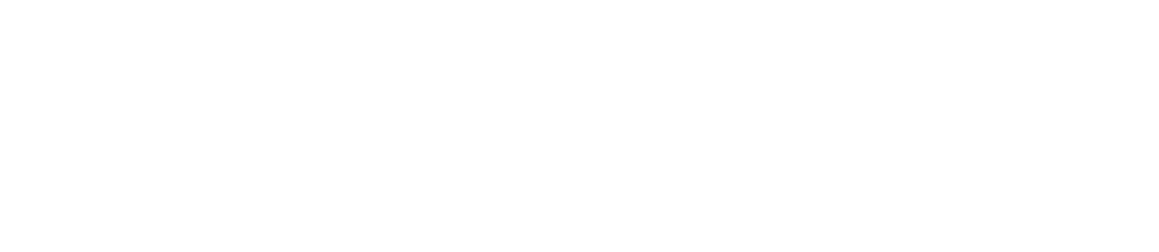


 Location: 台北101觀景台 
 Data Length: 17607 
 Name:  台北101觀景台
                lat           lng      comments      is_video         likes  \
count  1.760700e+04  1.760700e+04  17607.000000  17607.000000  17607.000000   
mean   2.503383e+01  1.215647e+02      1.397967      0.057477     47.982791   
std    4.668398e-12  5.468492e-11      3.614523      0.232759    619.471865   
min    2.503383e+01  1.215647e+02      0.000000      0.000000      0.000000   
25%    2.503383e+01  1.215647e+02      0.000000      0.000000      5.000000   
50%    2.503383e+01  1.215647e+02      0.000000      0.000000     15.000000   
75%    2.503383e+01  1.215647e+02      2.000000      0.000000     36.000000   
max    2.503383e+01  1.215647e+02    147.000000      1.000000  58169.000000   

           owner_id         month  
count  1.760700e+04  17607.000000  
mean   9.218043e+08      7.943943  
std    1.033137e+09      2.902616  
min    2.059000e+03      1.000000  
25%    1.452819e+08      6.000000  
50%    4.292

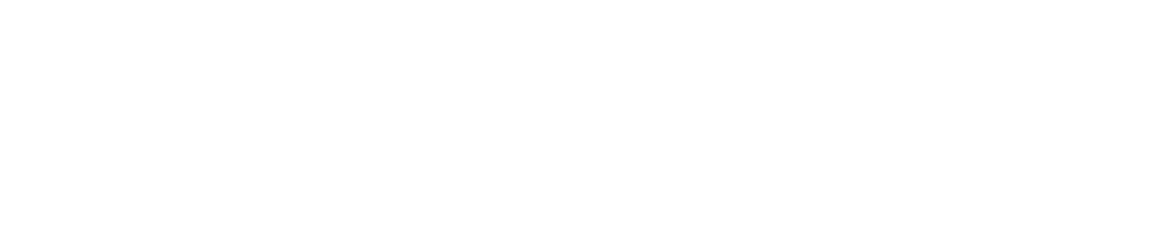


 Location: ATT 4 FUN 
 Data Length: 16411 
 Name:  ATT 4 FUN
                lat           lng      comments      is_video         likes  \
count  1.641100e+04  1.641100e+04  16411.000000  16411.000000  16411.000000   
mean   2.503533e+01  1.215659e+02      2.493571      0.074584     79.954786   
std    3.719805e-12  3.071059e-11      4.147127      0.262727    548.806284   
min    2.503533e+01  1.215659e+02      0.000000      0.000000      0.000000   
25%    2.503533e+01  1.215659e+02      0.000000      0.000000     12.000000   
50%    2.503533e+01  1.215659e+02      1.000000      0.000000     28.000000   
75%    2.503533e+01  1.215659e+02      3.000000      0.000000     59.000000   
max    2.503533e+01  1.215659e+02     90.000000      1.000000  26772.000000   

           owner_id         month  
count  1.641100e+04  16411.000000  
mean   8.607540e+08      8.025532  
std    8.847244e+08      2.973541  
min    1.242500e+04      1.000000  
25%    2.496217e+08      6.000000  
50%    4.8

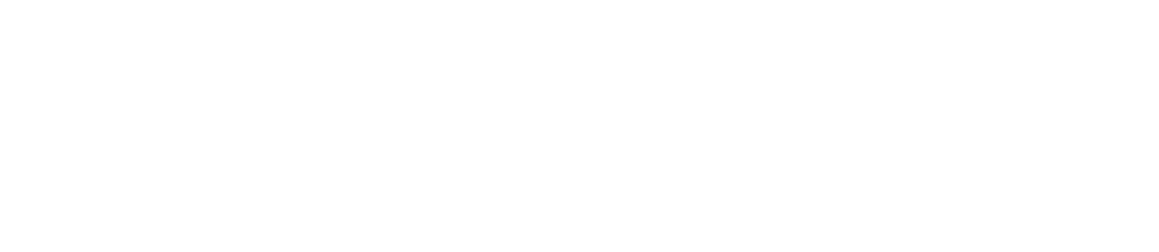


 Location: 信義區商圈 
 Data Length: 12747 
 Name:  信義區商圈
                lat           lng      comments      is_video         likes  \
count  1.274700e+04  1.274700e+04  12747.000000  12747.000000  12747.000000   
mean   2.503739e+01  1.215669e+02      2.506315      0.057818     72.172433   
std    2.923998e-12  1.296081e-11      4.120462      0.233407    374.885690   
min    2.503739e+01  1.215669e+02      0.000000      0.000000      0.000000   
25%    2.503739e+01  1.215669e+02      0.000000      0.000000     13.000000   
50%    2.503739e+01  1.215669e+02      1.000000      0.000000     28.000000   
75%    2.503739e+01  1.215669e+02      3.000000      0.000000     60.000000   
max    2.503739e+01  1.215669e+02     89.000000      1.000000  27058.000000   

           owner_id         month  
count  1.274700e+04  12747.000000  
mean   8.342362e+08      8.944536  
std    8.646773e+08      3.375173  
min    1.242500e+04      1.000000  
25%    2.596639e+08      7.000000  
50%    4.590615e+0

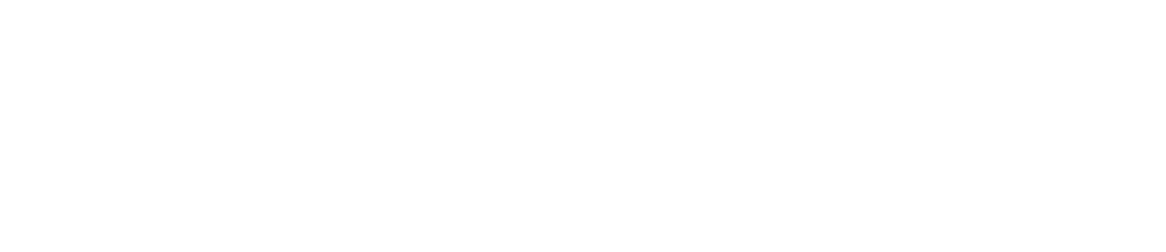


 Location: 饒河街觀光夜市 
 Data Length: 10926 
 Name:  饒河街觀光夜市
                lat           lng      comments      is_video         likes  \
count  1.092600e+04  1.092600e+04  10926.000000  10926.000000  10926.000000   
mean   2.505050e+01  1.215759e+02      2.090518      0.047135     64.641863   
std    4.508600e-12  6.935214e-12      3.978011      0.211938    761.803570   
min    2.505050e+01  1.215759e+02      0.000000      0.000000      0.000000   
25%    2.505050e+01  1.215759e+02      0.000000      0.000000      8.000000   
50%    2.505050e+01  1.215759e+02      1.000000      0.000000     22.000000   
75%    2.505050e+01  1.215759e+02      3.000000      0.000000     49.000000   
max    2.505050e+01  1.215759e+02    125.000000      1.000000  49188.000000   

           owner_id         month  
count  1.092600e+04  10926.000000  
mean   9.118957e+08      7.790683  
std    9.756060e+08      3.005994  
min    1.492000e+03      1.000000  
25%    2.110647e+08      6.000000  
50%    4.88913

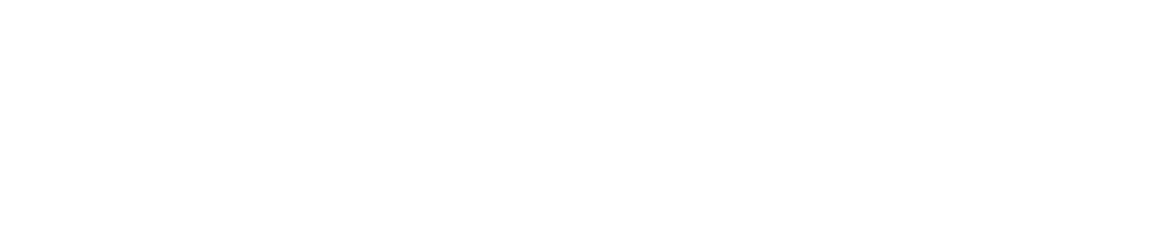


 Location: 四四南村 
 Data Length: 10570 
 Name:  四四南村
                lat           lng      comments      is_video         likes  \
count  1.057000e+04  1.057000e+04  10570.000000  10570.000000  10570.000000   
mean   2.503159e+01  1.215618e+02      2.446736      0.022611     75.349290   
std    3.723420e-12  5.002458e-12      4.935256      0.148667    552.066657   
min    2.503159e+01  1.215618e+02      0.000000      0.000000      0.000000   
25%    2.503159e+01  1.215618e+02      0.000000      0.000000     13.000000   
50%    2.503159e+01  1.215618e+02      1.000000      0.000000     31.000000   
75%    2.503159e+01  1.215618e+02      3.000000      0.000000     64.000000   
max    2.503159e+01  1.215618e+02    171.000000      1.000000  40834.000000   

           owner_id         month  
count  1.057000e+04  10570.000000  
mean   8.344022e+08      8.033113  
std    8.925130e+08      2.967041  
min    1.006500e+04      1.000000  
25%    2.224442e+08      6.000000  
50%    4.623157e+08 

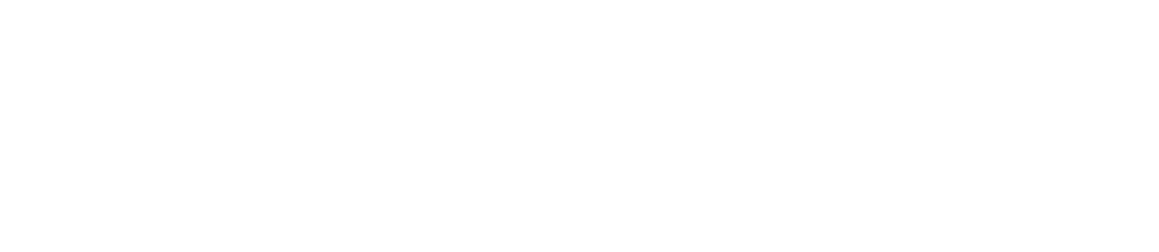


 Location: W Taipei 
 Data Length: 10531 
 Name:  W Taipei
                lat           lng      comments      is_video         likes  \
count  1.053100e+04  1.053100e+04  10531.000000  10531.000000  10531.000000   
mean   2.504084e+01  1.215656e+02      2.490837      0.046339    125.241762   
std    1.200874e-12  1.273353e-11      7.768773      0.210229    708.041295   
min    2.504084e+01  1.215656e+02      0.000000      0.000000      0.000000   
25%    2.504084e+01  1.215656e+02      0.000000      0.000000     12.000000   
50%    2.504084e+01  1.215656e+02      1.000000      0.000000     28.000000   
75%    2.504084e+01  1.215656e+02      3.000000      0.000000     62.000000   
max    2.504084e+01  1.215656e+02    524.000000      1.000000  24999.000000   

           owner_id         month  
count  1.053100e+04  10531.000000  
mean   6.925465e+08      7.610863  
std    8.676833e+08      3.311199  
min    4.781000e+03      1.000000  
25%    4.058536e+07      5.000000  
50%    3.161

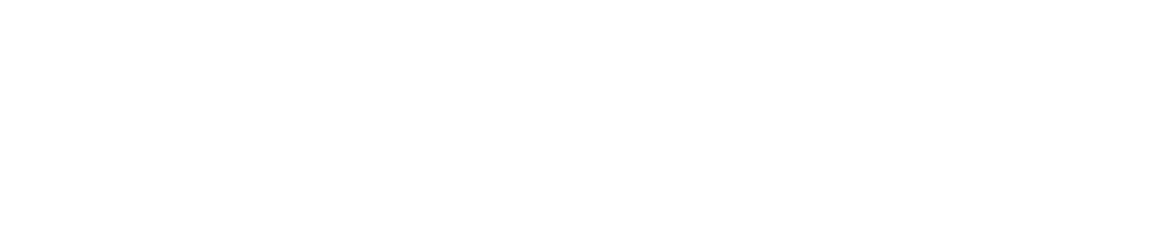


 Location: 大安森林公園 Da An Forest Park 
 Data Length: 9539 
 Name:  大安森林公園 Da An Forest Park
                lat           lng     comments     is_video         likes  \
count  9.539000e+03  9.539000e+03  9539.000000  9539.000000   9539.000000   
mean   2.503100e+01  1.215357e+02     2.105357     0.071601     54.029144   
std    4.334538e-13  8.640653e-12     4.015031     0.257839    419.366048   
min    2.503100e+01  1.215357e+02     0.000000     0.000000      0.000000   
25%    2.503100e+01  1.215357e+02     0.000000     0.000000      8.000000   
50%    2.503100e+01  1.215357e+02     1.000000     0.000000     22.000000   
75%    2.503100e+01  1.215357e+02     3.000000     0.000000     51.000000   
max    2.503100e+01  1.215357e+02   122.000000     1.000000  35140.000000   

           owner_id        month  
count  9.539000e+03  9539.000000  
mean   9.331600e+08     8.725862  
std    1.009383e+09     2.661912  
min    3.030300e+04     1.000000  
25%    2.157106e+08     7.000000  
50%  

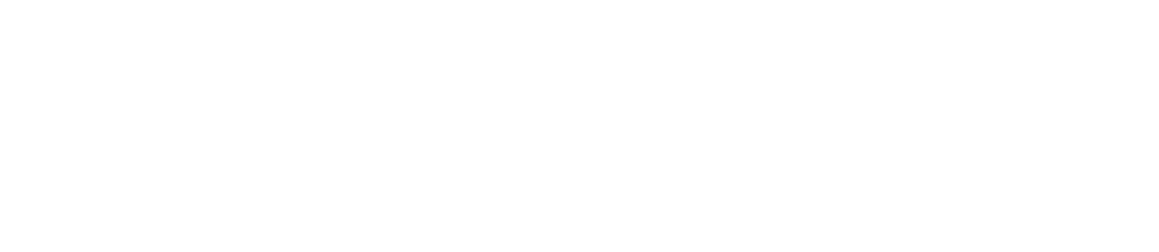


 Location: TICC 台北國際會議中心 
 Data Length: 9446 
 Name:  TICC 台北國際會議中心
                lat           lng     comments     is_video         likes  \
count  9.446000e+03  9.446000e+03  9446.000000  9446.000000   9446.000000   
mean   2.503347e+01  1.215607e+02     1.943786     0.170972     63.783189   
std    1.165352e-12  3.751864e-12     5.425419     0.376504    598.307761   
min    2.503347e+01  1.215607e+02     0.000000     0.000000      0.000000   
25%    2.503347e+01  1.215607e+02     0.000000     0.000000     10.000000   
50%    2.503347e+01  1.215607e+02     0.000000     0.000000     22.000000   
75%    2.503347e+01  1.215607e+02     2.000000     0.000000     45.000000   
max    2.503347e+01  1.215607e+02   343.000000     1.000000  44569.000000   

           owner_id        month  
count  9.446000e+03  9446.000000  
mean   9.051916e+08     8.228139  
std    9.313854e+08     2.893657  
min    1.472600e+04     1.000000  
25%    2.556981e+08     7.000000  
50%    4.857518e+08     8.0

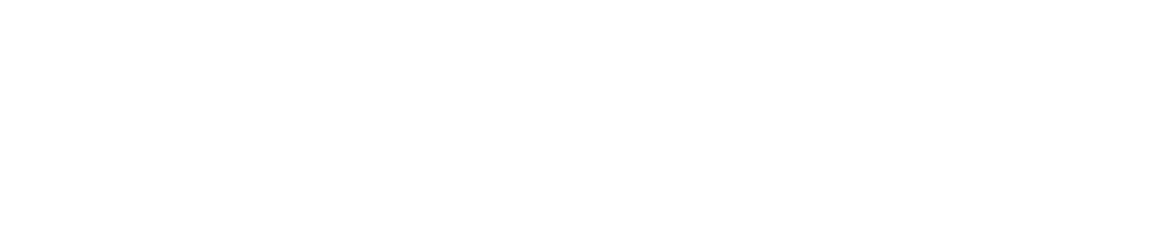


 Location: 花甜果室 
 Data Length: 9314 
 Name:  花甜果室
                lat           lng     comments     is_video         likes  \
count  9.314000e+03  9.314000e+03  9314.000000  9314.000000   9314.000000   
mean   2.504348e+01  1.215471e+02     3.294718     0.002791     74.253597   
std    1.609466e-12  1.878776e-11     8.985594     0.052764    293.577914   
min    2.504348e+01  1.215471e+02     0.000000     0.000000      0.000000   
25%    2.504348e+01  1.215471e+02     0.000000     0.000000     24.000000   
50%    2.504348e+01  1.215471e+02     2.000000     0.000000     43.000000   
75%    2.504348e+01  1.215471e+02     5.000000     0.000000     74.000000   
max    2.504348e+01  1.215471e+02   763.000000     1.000000  14129.000000   

           owner_id        month  
count  9.314000e+03  9314.000000  
mean   8.412465e+08     6.755207  
std    8.194551e+08     2.655087  
min    4.570000e+02     1.000000  
25%    2.873796e+08     5.000000  
50%    5.026221e+08     7.000000  
75%    1.3

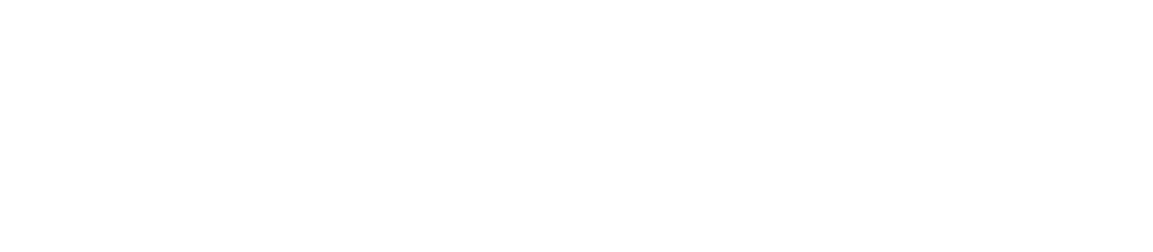


 Location: 台北東區 
 Data Length: 8856 
 Name:  台北東區
                lat           lng     comments     is_video         likes  \
count  8.856000e+03  8.856000e+03  8856.000000  8856.000000   8856.000000   
mean   2.504350e+01  1.215508e+02     2.587963     0.043925    100.779246   
std    8.136174e-13  6.963712e-13     4.221419     0.204940    910.460751   
min    2.504350e+01  1.215508e+02     0.000000     0.000000      0.000000   
25%    2.504350e+01  1.215508e+02     0.000000     0.000000     11.000000   
50%    2.504350e+01  1.215508e+02     1.000000     0.000000     26.000000   
75%    2.504350e+01  1.215508e+02     4.000000     0.000000     58.000000   
max    2.504350e+01  1.215508e+02    67.000000     1.000000  51580.000000   

           owner_id        month  
count  8.856000e+03  8856.000000  
mean   7.792886e+08     7.944444  
std    8.635548e+08     3.101787  
min    1.174200e+04     1.000000  
25%    2.100865e+08     6.000000  
50%    4.096095e+08     8.000000  
75%    1.2

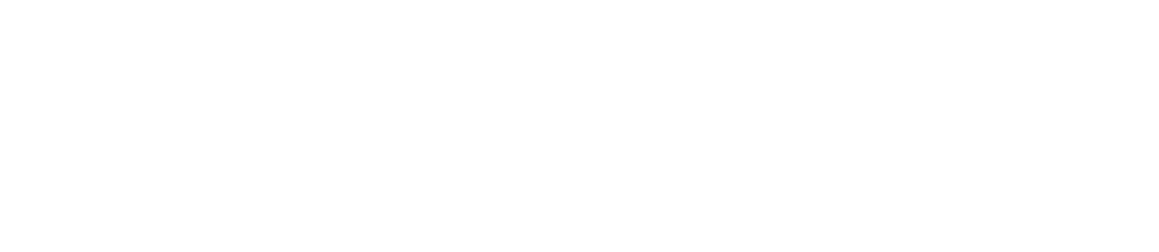


 Location: 誠品信義書店 
 Data Length: 8704 
 Name:  誠品信義書店
                lat           lng     comments     is_video         likes  \
count  8.704000e+03  8.704000e+03  8704.000000  8704.000000   8704.000000   
mean   2.503944e+01  1.215655e+02     1.787339     0.030790     74.630515   
std    1.570390e-12  1.379953e-11     6.312547     0.172759   1083.648949   
min    2.503944e+01  1.215655e+02     0.000000     0.000000      0.000000   
25%    2.503944e+01  1.215655e+02     0.000000     0.000000      5.000000   
50%    2.503944e+01  1.215655e+02     0.000000     0.000000     14.000000   
75%    2.503944e+01  1.215655e+02     2.000000     0.000000     34.000000   
max    2.503944e+01  1.215655e+02   401.000000     1.000000  56276.000000   

           owner_id        month  
count  8.704000e+03  8704.000000  
mean   8.459419e+08     7.373621  
std    9.342301e+08     3.183481  
min    1.243900e+04     1.000000  
25%    1.901216e+08     5.000000  
50%    4.214336e+08     8.000000  
75%   

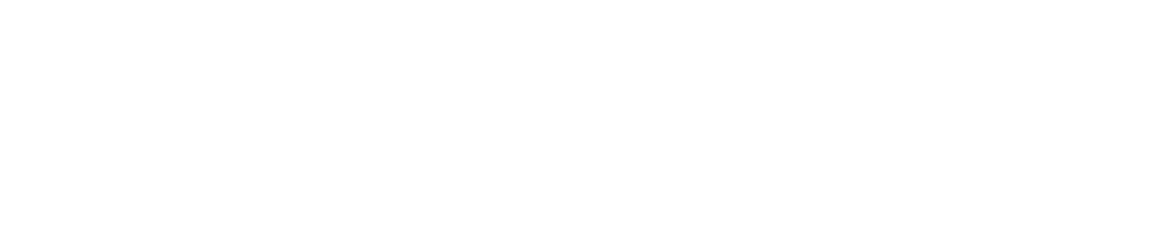


 Location: 點點心台灣 Dimdimsum Taiwan 
 Data Length: 8562 
 Name:  點點心台灣 Dimdimsum Taiwan
                lat           lng     comments     is_video         likes  \
count  8.562000e+03  8.562000e+03  8562.000000  8562.000000   8562.000000   
mean   2.504080e+01  1.215671e+02     3.100093     0.142957     61.173674   
std    2.760620e-12  2.836652e-11     4.050453     0.350050    402.058501   
min    2.504080e+01  1.215671e+02     0.000000     0.000000      0.000000   
25%    2.504080e+01  1.215671e+02     0.000000     0.000000     16.000000   
50%    2.504080e+01  1.215671e+02     2.000000     0.000000     30.000000   
75%    2.504080e+01  1.215671e+02     4.000000     0.000000     56.000000   
max    2.504080e+01  1.215671e+02    73.000000     1.000000  30806.000000   

           owner_id        month  
count  8.562000e+03  8562.000000  
mean   7.057711e+08     7.080472  
std    8.059498e+08     3.076518  
min    1.102400e+04     1.000000  
25%    2.278103e+08     5.000000  
50%    3.

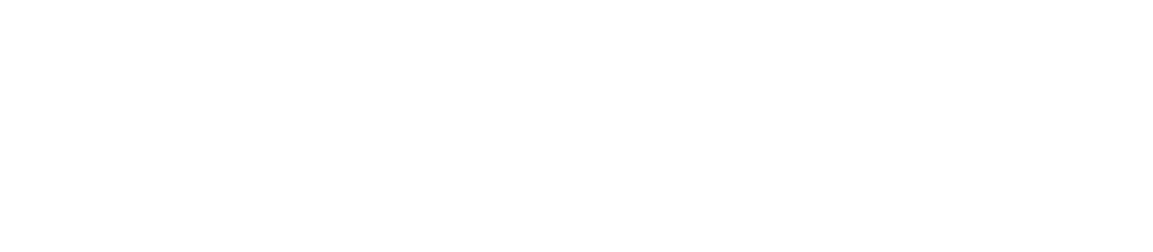


 Location: 國立國父紀念館National Dr.Sun Yat-sen Memorial Hall 
 Data Length: 8558 
 Name:  國立國父紀念館National Dr.Sun Yat-sen Memorial Hall
                lat           lng     comments     is_video         likes  \
count  8.558000e+03  8.558000e+03  8558.000000  8558.000000   8558.000000   
mean   2.503968e+01  1.215597e+02     1.702617     0.086235     60.663940   
std    4.572610e-12  1.691191e-11     4.156152     0.280727    899.899028   
min    2.503968e+01  1.215597e+02     0.000000     0.000000      0.000000   
25%    2.503968e+01  1.215597e+02     0.000000     0.000000      6.000000   
50%    2.503968e+01  1.215597e+02     0.000000     0.000000     17.000000   
75%    2.503968e+01  1.215597e+02     2.000000     0.000000     43.000000   
max    2.503968e+01  1.215597e+02   147.000000     1.000000  69504.000000   

           owner_id        month  
count  8.558000e+03  8558.000000  
mean   9.201942e+08     8.394952  
std    9.934021e+08     3.251613  
min    1.071400e+04     1.000000  


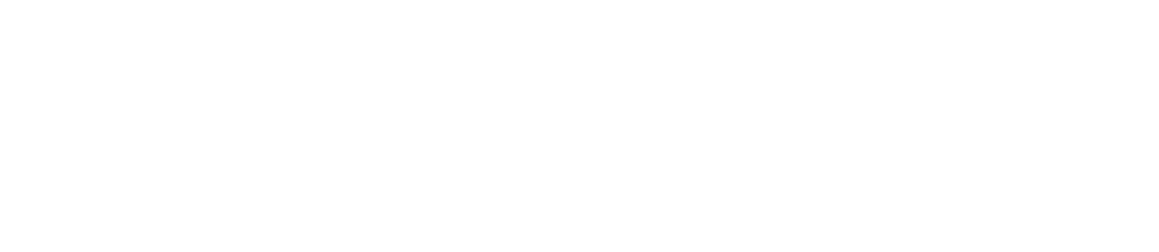


 Location: Mandarin Oriental, Taipei 台北文華東方酒店 
 Data Length: 8319 
 Name:  Mandarin Oriental, Taipei 台北文華東方酒店
                lat           lng     comments     is_video         likes  \
count  8.319000e+03  8.319000e+03  8319.000000  8319.000000   8319.000000   
mean   2.505567e+01  1.215482e+02     2.365188     0.026686     93.851905   
std    2.181497e-12  7.390089e-12     5.774459     0.161173    569.995500   
min    2.505567e+01  1.215482e+02     0.000000     0.000000      0.000000   
25%    2.505567e+01  1.215482e+02     0.000000     0.000000     11.000000   
50%    2.505567e+01  1.215482e+02     1.000000     0.000000     26.000000   
75%    2.505567e+01  1.215482e+02     3.000000     0.000000     55.000000   
max    2.505567e+01  1.215482e+02   140.000000     1.000000  23232.000000   

           owner_id        month  
count  8.319000e+03  8319.000000  
mean   8.063425e+08     8.078255  
std    1.001365e+09     3.509134  
min    1.550000e+03     1.000000  
25%    4.350365e+07 

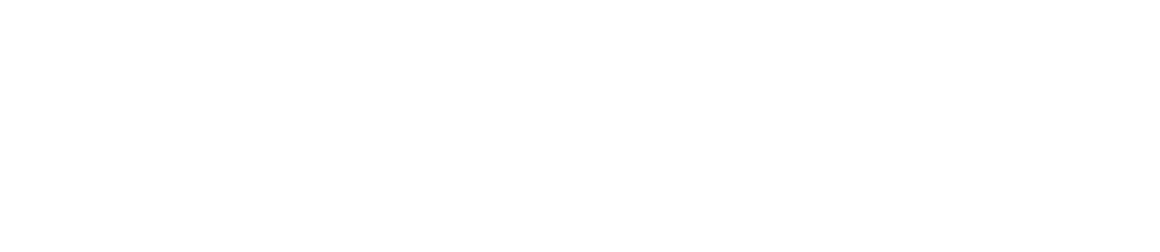


 Location: Okey Dokey 
 Data Length: 8083 
 Name:  Okey Dokey
                lat           lng     comments     is_video         likes  \
count  8.083000e+03  8.083000e+03  8083.000000  8083.000000   8083.000000   
mean   2.503884e+01  1.215558e+02     3.364716     0.132748     93.057528   
std    3.961521e-12  1.549079e-11     4.252295     0.339323    528.987419   
min    2.503884e+01  1.215558e+02     0.000000     0.000000      0.000000   
25%    2.503884e+01  1.215558e+02     0.000000     0.000000     22.000000   
50%    2.503884e+01  1.215558e+02     2.000000     0.000000     41.000000   
75%    2.503884e+01  1.215558e+02     5.000000     0.000000     74.000000   
max    2.503884e+01  1.215558e+02    59.000000     1.000000  30233.000000   

           owner_id        month  
count  8.083000e+03  8083.000000  
mean   6.498723e+08     8.044662  
std    7.717418e+08     2.476139  
min    1.582200e+04     3.000000  
25%    2.325721e+08     6.000000  
50%    3.519100e+08     8.000000 

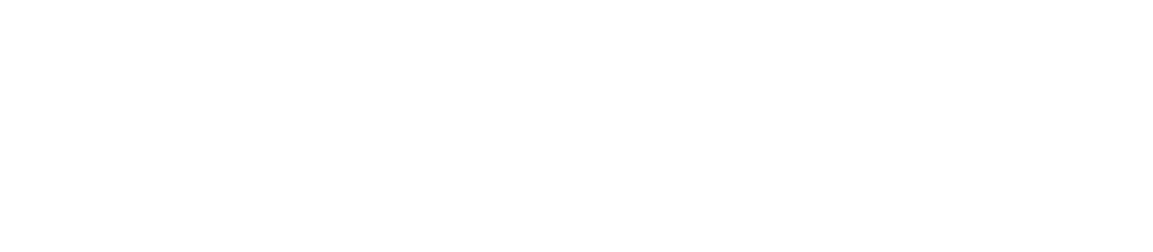


 Location: 微風信義 Breeze Xin Yi 
 Data Length: 7888 
 Name:  微風信義 Breeze Xin Yi
                lat           lng     comments     is_video         likes  \
count  7.888000e+03  7.888000e+03  7888.000000  7888.000000   7888.000000   
mean   2.504078e+01  1.215667e+02     2.644016     0.047794     97.161131   
std    2.138869e-12  3.368186e-12     4.775662     0.213344    565.920210   
min    2.504078e+01  1.215667e+02     0.000000     0.000000      0.000000   
25%    2.504078e+01  1.215667e+02     0.000000     0.000000     11.000000   
50%    2.504078e+01  1.215667e+02     1.000000     0.000000     26.000000   
75%    2.504078e+01  1.215667e+02     3.000000     0.000000     56.000000   
max    2.504078e+01  1.215667e+02   170.000000     1.000000  18985.000000   

           owner_id        month  
count  7.888000e+03  7888.000000  
mean   7.851494e+08     7.536511  
std    8.921415e+08     3.400257  
min    1.319900e+04     1.000000  
25%    1.898197e+08     5.000000  
50%    3.695077e+

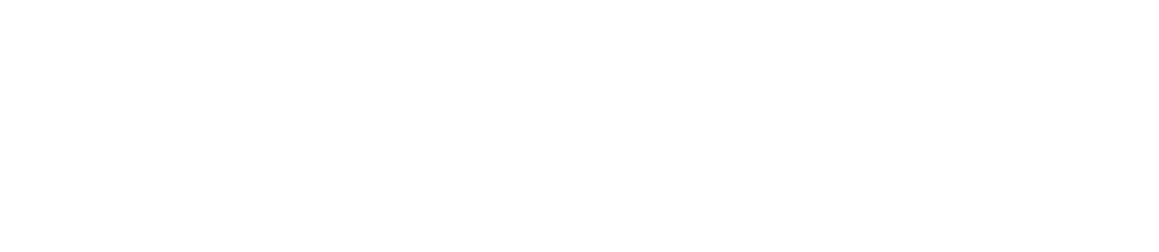


 Location: SYNTREND 三創生活園區 
 Data Length: 7686 
 Name:  SYNTREND 三創生活園區
                lat           lng     comments     is_video         likes  \
count  7.686000e+03  7.686000e+03  7686.000000  7686.000000   7686.000000   
mean   2.504506e+01  1.215319e+02     1.740437     0.070778     85.866511   
std    1.605931e-12  1.760839e-11     4.549835     0.256470   1276.035250   
min    2.504506e+01  1.215319e+02     0.000000     0.000000      0.000000   
25%    2.504506e+01  1.215319e+02     0.000000     0.000000      6.000000   
50%    2.504506e+01  1.215319e+02     0.000000     0.000000     16.000000   
75%    2.504506e+01  1.215319e+02     2.000000     0.000000     35.750000   
max    2.504506e+01  1.215319e+02   197.000000     1.000000  57570.000000   

           owner_id        month  
count  7.686000e+03  7686.000000  
mean   9.132164e+08     8.155347  
std    9.737050e+08     3.354262  
min    1.242500e+04     1.000000  
25%    2.087276e+08     5.000000  
50%    4.815939e+08    

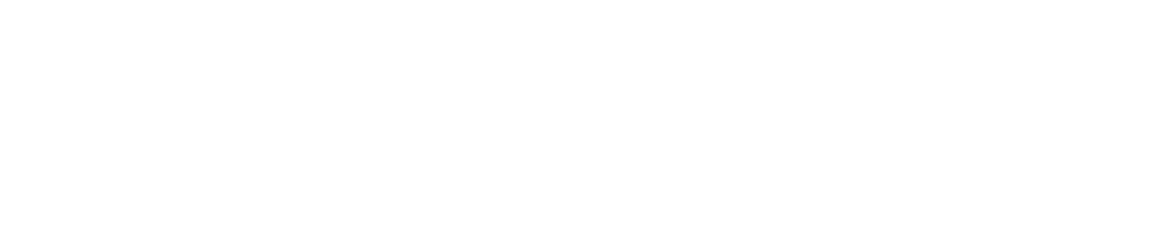


 Location: 三井上引水產 
 Data Length: 7447 
 Name:  三井上引水產
                lat           lng     comments     is_video         likes  \
count  7.447000e+03  7.447000e+03  7447.000000  7447.000000   7447.000000   
mean   2.506672e+01  1.215369e+02     1.884249     0.025111     50.824762   
std    2.014524e-12  9.521912e-12     3.664045     0.156472    297.575442   
min    2.506672e+01  1.215369e+02     0.000000     0.000000      0.000000   
25%    2.506672e+01  1.215369e+02     0.000000     0.000000      8.000000   
50%    2.506672e+01  1.215369e+02     1.000000     0.000000     19.000000   
75%    2.506672e+01  1.215369e+02     2.000000     0.000000     40.000000   
max    2.506672e+01  1.215369e+02   165.000000     1.000000  13408.000000   

           owner_id        month  
count  7.447000e+03  7447.000000  
mean   6.737964e+08     7.321606  
std    8.487483e+08     3.526401  
min    5.750000e+02     1.000000  
25%    4.301515e+07     5.000000  
50%    3.178331e+08     8.000000  
75%   

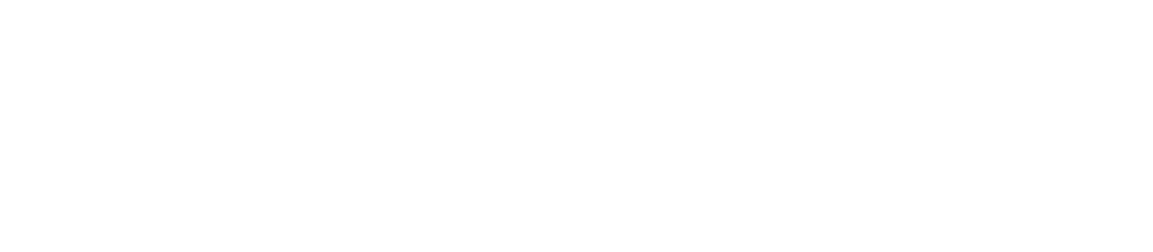


 Location: 統一時代百貨台北店 
 Data Length: 6931 
 Name:  統一時代百貨台北店
                lat           lng     comments     is_video         likes  \
count  6.931000e+03  6.931000e+03  6931.000000  6931.000000   6931.000000   
mean   2.504069e+01  1.215651e+02     1.843890     0.049344     59.116001   
std    1.755167e-12  7.560720e-12     3.769573     0.216600    427.609666   
min    2.504069e+01  1.215651e+02     0.000000     0.000000      0.000000   
25%    2.504069e+01  1.215651e+02     0.000000     0.000000      8.000000   
50%    2.504069e+01  1.215651e+02     0.000000     0.000000     19.000000   
75%    2.504069e+01  1.215651e+02     2.000000     0.000000     42.000000   
max    2.504069e+01  1.215651e+02   124.000000     1.000000  24753.000000   

           owner_id        month  
count  6.931000e+03  6931.000000  
mean   9.579307e+08     8.638436  
std    9.365566e+08     3.497885  
min    1.243900e+04     1.000000  
25%    2.625555e+08     6.000000  
50%    5.375827e+08    10.000000  


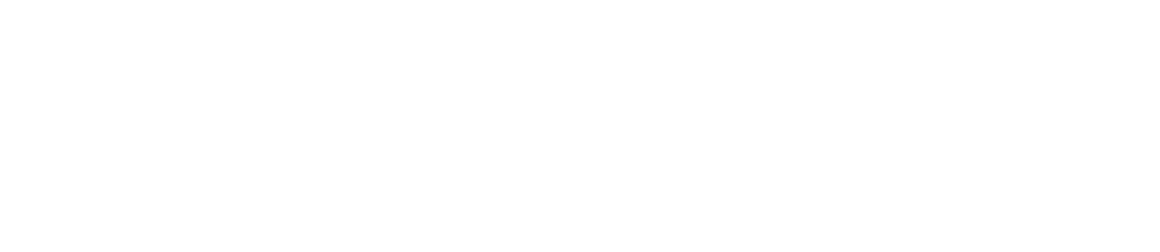


 Location: Grand Hyatt Taipei - 台北君悅酒店 
 Data Length: 6795 
 Name:  Grand Hyatt Taipei - 台北君悅酒店
                lat           lng     comments     is_video         likes  \
count  6.795000e+03  6.795000e+03  6795.000000  6795.000000   6795.000000   
mean   2.503549e+01  1.215627e+02     2.271523     0.045916    108.036645   
std    2.902781e-12  1.034626e-11     4.351059     0.209319    748.034547   
min    2.503549e+01  1.215627e+02     0.000000     0.000000      0.000000   
25%    2.503549e+01  1.215627e+02     0.000000     0.000000     11.000000   
50%    2.503549e+01  1.215627e+02     1.000000     0.000000     25.000000   
75%    2.503549e+01  1.215627e+02     3.000000     0.000000     53.000000   
max    2.503549e+01  1.215627e+02   123.000000     1.000000  32716.000000   

           owner_id        month  
count  6.795000e+03  6795.000000  
mean   8.209784e+08     7.947609  
std    9.213939e+08     3.325076  
min    1.726000e+04     1.000000  
25%    1.964403e+08     6.000000  

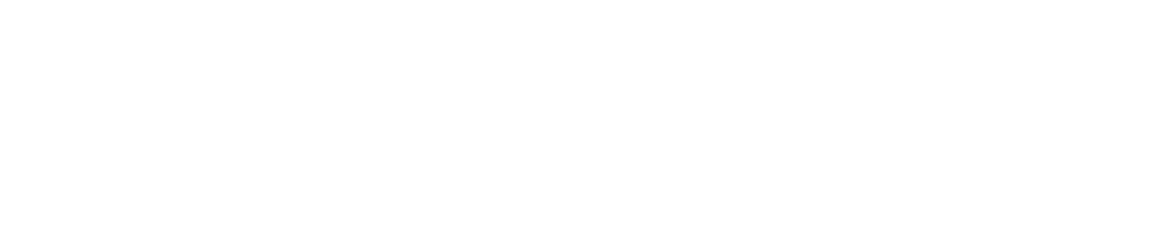


 Location: YumYum Deli 
 Data Length: 6127 
 Name:  YumYum Deli
                lat           lng     comments     is_video         likes  \
count  6.127000e+03  6.127000e+03  6127.000000  6127.000000   6127.000000   
mean   2.503977e+01  1.215523e+02     3.183287     0.024808    119.428595   
std    2.302346e-12  1.185282e-11     7.487209     0.155553    526.789120   
min    2.503977e+01  1.215523e+02     0.000000     0.000000      0.000000   
25%    2.503977e+01  1.215523e+02     0.000000     0.000000     25.000000   
50%    2.503977e+01  1.215523e+02     2.000000     0.000000     47.000000   
75%    2.503977e+01  1.215523e+02     4.000000     0.000000     83.000000   
max    2.503977e+01  1.215523e+02   324.000000     1.000000  13801.000000   

           owner_id        month  
count  6.127000e+03  6127.000000  
mean   6.954566e+08     6.961319  
std    7.515553e+08     3.109594  
min    1.885200e+04     1.000000  
25%    2.444799e+08     5.000000  
50%    3.752189e+08     8.00000

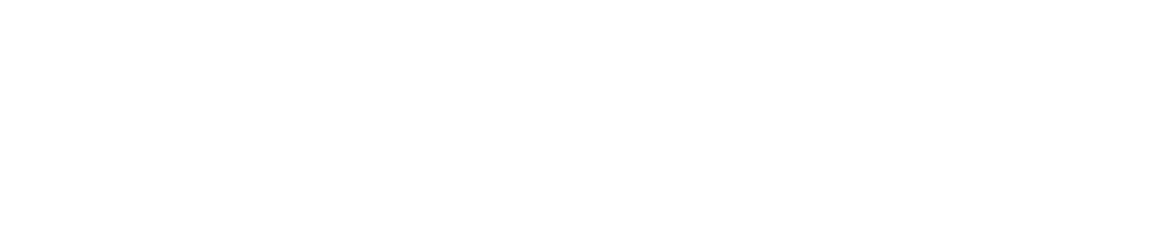


 Location: 新光三越台北信義新天地 A11 
 Data Length: 5819 
 Name:  新光三越台北信義新天地 A11
                lat           lng     comments     is_video         likes  \
count  5.819000e+03  5.819000e+03  5819.000000  5819.000000   5819.000000   
mean   2.503587e+01  1.215673e+02     2.271524     0.050868     80.024747   
std    2.021668e-12  1.165390e-12     5.826455     0.219747    425.797987   
min    2.503587e+01  1.215673e+02     0.000000     0.000000      0.000000   
25%    2.503587e+01  1.215673e+02     0.000000     0.000000     10.000000   
50%    2.503587e+01  1.215673e+02     1.000000     0.000000     23.000000   
75%    2.503587e+01  1.215673e+02     3.000000     0.000000     50.000000   
max    2.503587e+01  1.215673e+02   288.000000     1.000000  17967.000000   

           owner_id        month  
count  5.819000e+03  5819.000000  
mean   9.279888e+08     9.188864  
std    9.563869e+08     3.102728  
min    3.517000e+03     1.000000  
25%    2.413984e+08     7.000000  
50%    4.983952e+08    

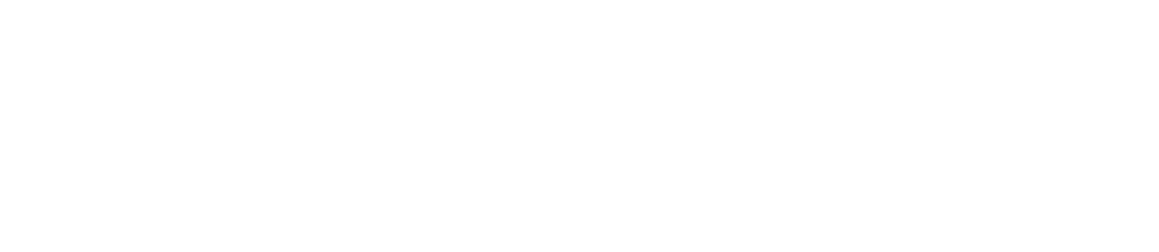


 Location: 台北萬豪酒店 Taipei Marriott Hotel 
 Data Length: 5758 
 Name:  台北萬豪酒店 Taipei Marriott Hotel
                lat           lng     comments     is_video          likes  \
count  5.758000e+03  5.758000e+03  5758.000000  5758.000000    5758.000000   
mean   2.508006e+01  1.215604e+02     2.183050     0.035776     164.379819   
std    3.481962e-13  2.401843e-12     8.852418     0.185748    2690.383908   
min    2.508006e+01  1.215604e+02     0.000000     0.000000       0.000000   
25%    2.508006e+01  1.215604e+02     0.000000     0.000000      11.000000   
50%    2.508006e+01  1.215604e+02     1.000000     0.000000      22.000000   
75%    2.508006e+01  1.215604e+02     3.000000     0.000000      49.000000   
max    2.508006e+01  1.215604e+02   614.000000     1.000000  192581.000000   

           owner_id        month  
count  5.758000e+03  5758.000000  
mean   7.341250e+08     8.102119  
std    9.139917e+08     3.388204  
min    3.785000e+03     1.000000  
25%    4.312580e+07    

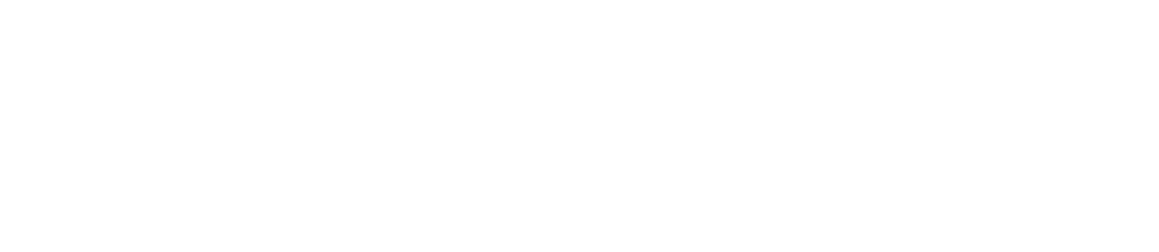


 Location: COMMUNE A7 
 Data Length: 5749 
 Name:  COMMUNE A7
                lat           lng     comments     is_video         likes  \
count  5.749000e+03  5.749000e+03  5749.000000  5749.000000   5749.000000   
mean   2.503607e+01  1.215661e+02     2.366672     0.038094     94.047139   
std    9.486571e-13  3.481962e-12     3.534280     0.191439    472.194603   
min    2.503607e+01  1.215661e+02     0.000000     0.000000      0.000000   
25%    2.503607e+01  1.215661e+02     0.000000     0.000000     18.000000   
50%    2.503607e+01  1.215661e+02     1.000000     0.000000     37.000000   
75%    2.503607e+01  1.215661e+02     3.000000     0.000000     68.000000   
max    2.503607e+01  1.215661e+02    49.000000     1.000000  12111.000000   

           owner_id        month  
count  5.749000e+03  5749.000000  
mean   6.520564e+08    11.999826  
std    8.491944e+08     0.013189  
min    1.365900e+04    11.000000  
25%    1.875716e+08    12.000000  
50%    3.241727e+08    12.000000 

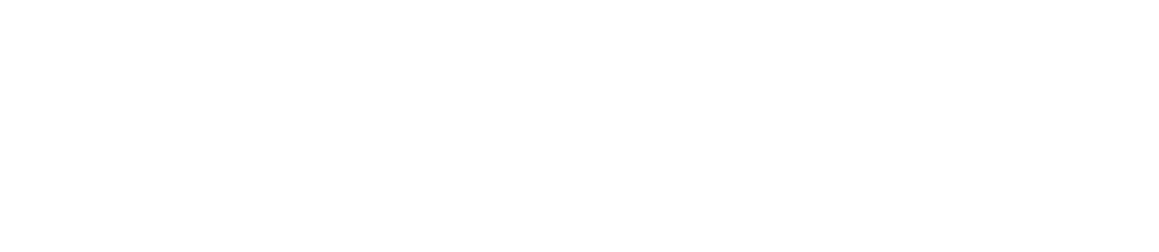


 Location: September Café 
 Data Length: 5069 
 Name:  September Café
                lat           lng     comments     is_video         likes  \
count  5.069000e+03  5.069000e+03  5069.000000  5069.000000   5069.000000   
mean   2.503664e+01  1.215483e+02     2.415664     0.014401     79.995463   
std    3.485556e-12  2.501357e-12     3.355696     0.119150    274.100208   
min    2.503664e+01  1.215483e+02     0.000000     0.000000      0.000000   
25%    2.503664e+01  1.215483e+02     0.000000     0.000000     19.000000   
50%    2.503664e+01  1.215483e+02     1.000000     0.000000     37.000000   
75%    2.503664e+01  1.215483e+02     3.000000     0.000000     72.000000   
max    2.503664e+01  1.215483e+02    43.000000     1.000000  12708.000000   

           owner_id        month  
count  5.069000e+03  5069.000000  
mean   5.752338e+08     7.128822  
std    7.531128e+08     3.409412  
min    1.577000e+04     1.000000  
25%    1.771028e+08     4.000000  
50%    3.107083e+08     8

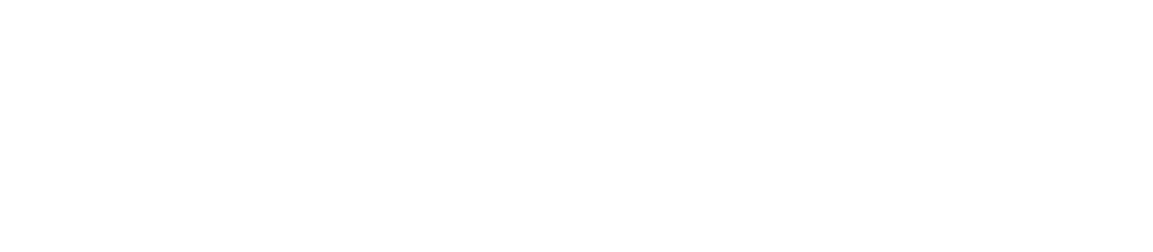


 Location: Shangri-La Taipei 香格里拉台北遠東國際大飯店 
 Data Length: 4941 
 Name:  Shangri-La Taipei 香格里拉台北遠東國際大飯店
                lat           lng     comments     is_video         likes  \
count  4.941000e+03  4.941000e+03  4941.000000  4941.000000   4941.000000   
mean   2.502661e+01  1.215492e+02     2.427444     0.034608     80.236592   
std    7.390392e-13  9.820694e-12    28.726031     0.182804    523.695455   
min    2.502661e+01  1.215492e+02     0.000000     0.000000      0.000000   
25%    2.502661e+01  1.215492e+02     0.000000     0.000000      9.000000   
50%    2.502661e+01  1.215492e+02     0.000000     0.000000     22.000000   
75%    2.502661e+01  1.215492e+02     2.000000     0.000000     48.000000   
max    2.502661e+01  1.215492e+02  1998.000000     1.000000  24841.000000   

           owner_id        month  
count  4.941000e+03  4941.000000  
mean   8.241441e+08     7.669298  
std    9.100701e+08     3.274909  
min    1.812900e+04     1.000000  
25%    1.953243e+08     5.

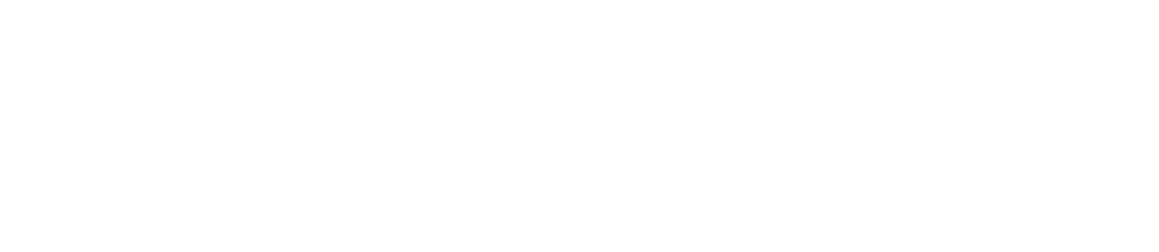


 Location: Elektro 
 Data Length: 4902 
 Name:  Elektro
                lat           lng     comments     is_video         likes  \
count  4.902000e+03  4.902000e+03  4902.000000  4902.000000   4902.000000   
mean   2.503570e+01  1.215660e+02     4.009588     0.176051    100.045084   
std    3.041433e-12  5.940743e-12     4.967689     0.380902    290.198102   
min    2.503570e+01  1.215660e+02     0.000000     0.000000      0.000000   
25%    2.503570e+01  1.215660e+02     1.000000     0.000000     27.000000   
50%    2.503570e+01  1.215660e+02     2.000000     0.000000     52.000000   
75%    2.503570e+01  1.215660e+02     5.000000     0.000000     97.000000   
max    2.503570e+01  1.215660e+02    83.000000     1.000000  11292.000000   

           owner_id        month  
count  4.902000e+03  4902.000000  
mean   5.521369e+08     7.546716  
std    6.416022e+08     3.303859  
min    2.115300e+04     1.000000  
25%    2.137239e+08     5.000000  
50%    3.361968e+08     7.000000  
75% 

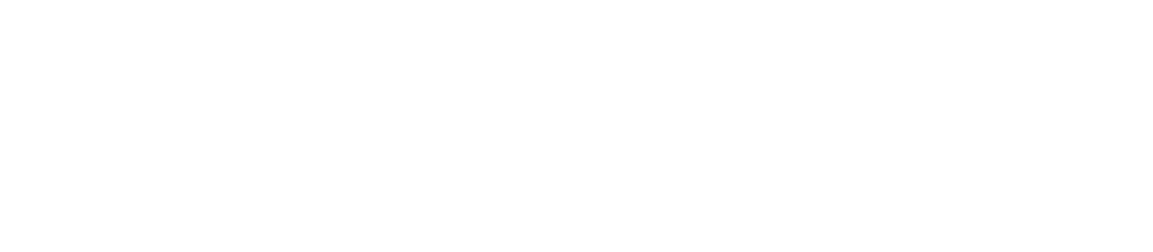


 Location: Bobii Frutii珍珠水果特調 
 Data Length: 4796 
 Name:  Bobii Frutii珍珠水果特調
                lat           lng     comments     is_video         likes  \
count  4.796000e+03  4.796000e+03  4796.000000  4796.000000   4796.000000   
mean   2.504266e+01  1.215502e+02     3.297540     0.005004    104.395746   
std    2.526243e-12  1.213734e-11     4.202745     0.070570    712.279053   
min    2.504266e+01  1.215502e+02     0.000000     0.000000      0.000000   
25%    2.504266e+01  1.215502e+02     0.000000     0.000000     27.000000   
50%    2.504266e+01  1.215502e+02     2.000000     0.000000     50.000000   
75%    2.504266e+01  1.215502e+02     5.000000     0.000000     88.000000   
max    2.504266e+01  1.215502e+02    69.000000     1.000000  38353.000000   

           owner_id        month  
count  4.796000e+03  4796.000000  
mean   8.689516e+08     7.928691  
std    8.753669e+08     2.021140  
min    2.962900e+04     5.000000  
25%    2.878036e+08     6.000000  
50%    5.042383e+

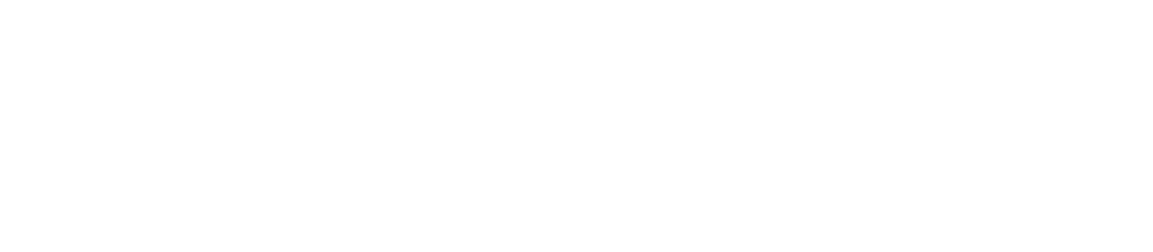


 Location: REVEL 樂福 新美式餐廳 
 Data Length: 4666 
 Name:  REVEL 樂福 新美式餐廳
                lat           lng     comments     is_video         likes  \
count  4.666000e+03  4.666000e+03  4666.000000  4666.000000   4666.000000   
mean   2.504091e+01  1.215459e+02     2.596871     0.045435     92.864552   
std    1.161862e-12  1.098617e-11     4.088326     0.208279    604.192066   
min    2.504091e+01  1.215459e+02     0.000000     0.000000      0.000000   
25%    2.504091e+01  1.215459e+02     0.000000     0.000000     21.000000   
50%    2.504091e+01  1.215459e+02     1.000000     0.000000     39.000000   
75%    2.504091e+01  1.215459e+02     4.000000     0.000000     73.000000   
max    2.504091e+01  1.215459e+02    86.000000     1.000000  36935.000000   

           owner_id        month  
count  4.666000e+03  4666.000000  
mean   7.506163e+08     7.883198  
std    8.283825e+08     3.007862  
min    1.384500e+04     1.000000  
25%    2.411315e+08     6.000000  
50%    3.809364e+08     8

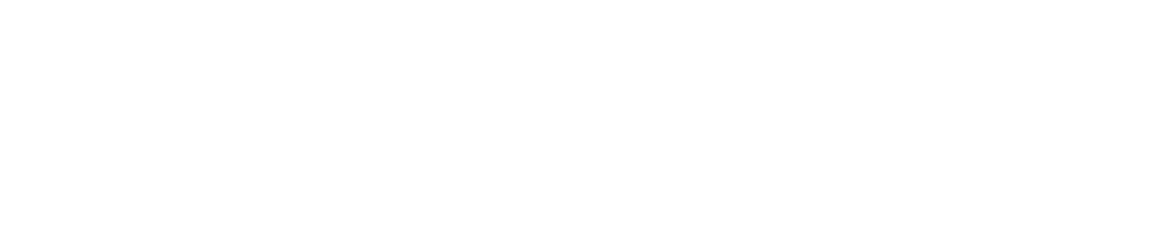


 Location: 和茗甘味處-忠孝店 
 Data Length: 4615 
 Name:  和茗甘味處-忠孝店
                lat           lng    comments     is_video         likes  \
count  4.615000e+03  4.615000e+03  4615.00000  4615.000000   4615.000000   
mean   2.504391e+01  1.215474e+02     3.59740     0.215601    128.427736   
std    1.876036e-12  4.377418e-12     6.25138     0.411283   1086.542087   
min    2.504391e+01  1.215474e+02     0.00000     0.000000      0.000000   
25%    2.504391e+01  1.215474e+02     0.00000     0.000000     18.000000   
50%    2.504391e+01  1.215474e+02     2.00000     0.000000     35.000000   
75%    2.504391e+01  1.215474e+02     5.00000     0.000000     64.000000   
max    2.504391e+01  1.215474e+02   162.00000     1.000000  43559.000000   

           owner_id        month  
count  4.615000e+03  4615.000000  
mean   8.874203e+08     6.809534  
std    8.647299e+08     3.426976  
min    1.401800e+04     1.000000  
25%    2.884620e+08     4.000000  
50%    5.249854e+08     7.000000  
75%    1.

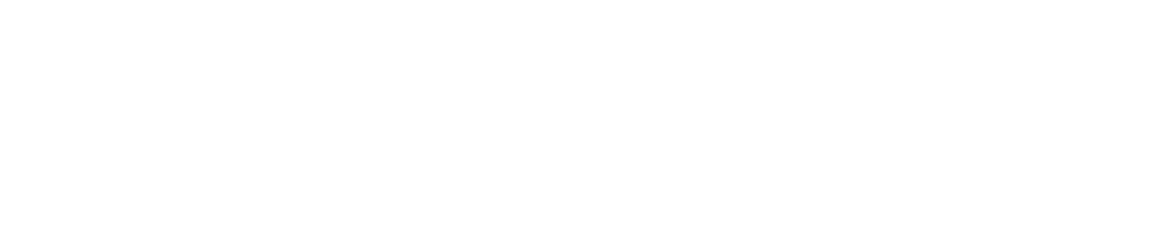


 Location: Da'an District, Taipei 
 Data Length: 4341 
 Name:  Da'an District, Taipei
                lat           lng     comments     is_video        likes  \
count  4.341000e+03  4.341000e+03  4341.000000  4341.000000  4341.000000   
mean   2.502639e+01  1.215344e+02     2.252707     0.055056    56.390002   
std    1.144106e-12  9.962957e-12     5.514827     0.228117   205.553727   
min    2.502639e+01  1.215344e+02     0.000000     0.000000     0.000000   
25%    2.502639e+01  1.215344e+02     0.000000     0.000000    10.000000   
50%    2.502639e+01  1.215344e+02     1.000000     0.000000    22.000000   
75%    2.502639e+01  1.215344e+02     3.000000     0.000000    48.000000   
max    2.502639e+01  1.215344e+02   144.000000     1.000000  7789.000000   

           owner_id        month  
count  4.341000e+03  4341.000000  
mean   9.607332e+08     9.647086  
std    1.154523e+09     2.848532  
min    3.400000e+01     1.000000  
25%    3.539726e+07    10.000000  
50%    3.688178e+0

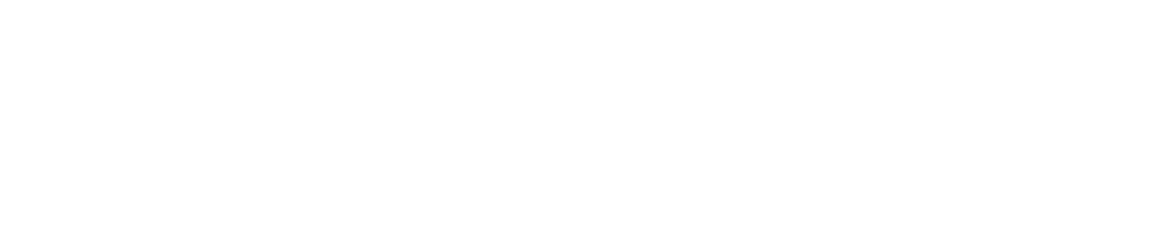


 Location: Woolloomooloo 
 Data Length: 4313 
 Name:  Woolloomooloo
                lat           lng     comments     is_video         likes  \
count  4.313000e+03  4.313000e+03  4313.000000  4313.000000   4313.000000   
mean   2.503325e+01  1.215581e+02     2.329005     0.012752     76.166242   
std    2.469422e-12  9.039152e-12     3.498679     0.112216    380.472644   
min    2.503325e+01  1.215581e+02     0.000000     0.000000      0.000000   
25%    2.503325e+01  1.215581e+02     0.000000     0.000000     15.000000   
50%    2.503325e+01  1.215581e+02     1.000000     0.000000     29.000000   
75%    2.503325e+01  1.215581e+02     3.000000     0.000000     55.000000   
max    2.503325e+01  1.215581e+02    61.000000     1.000000  11460.000000   

           owner_id        month  
count  4.313000e+03  4313.000000  
mean   6.082137e+08     6.668444  
std    8.055832e+08     3.375395  
min    1.325100e+04     1.000000  
25%    5.026146e+07     4.000000  
50%    3.031240e+08     7.0

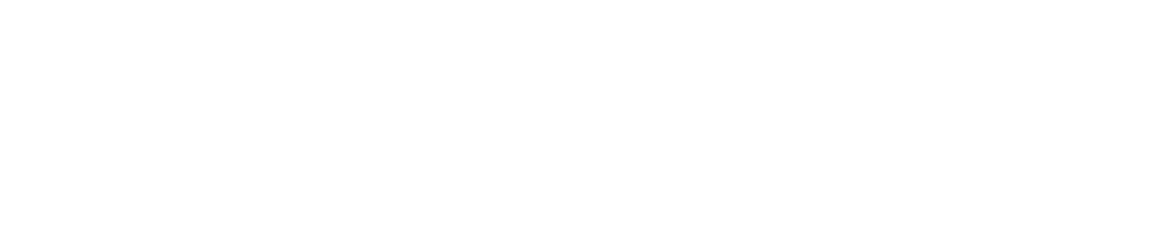


 Location: 誠品書店敦南店 
 Data Length: 4233 
 Name:  誠品書店敦南店
                lat           lng     comments     is_video         likes  \
count  4.233000e+03  4.233000e+03  4233.000000  4233.000000   4233.000000   
mean   2.503963e+01  1.215493e+02     1.574297     0.026931     67.620600   
std    1.428360e-12  9.053384e-12     3.726435     0.161902    871.277158   
min    2.503963e+01  1.215493e+02     0.000000     0.000000      0.000000   
25%    2.503963e+01  1.215493e+02     0.000000     0.000000      5.000000   
50%    2.503963e+01  1.215493e+02     0.000000     0.000000     13.000000   
75%    2.503963e+01  1.215493e+02     2.000000     0.000000     30.000000   
max    2.503963e+01  1.215493e+02    90.000000     1.000000  34204.000000   

           owner_id        month  
count  4.233000e+03  4233.000000  
mean   8.151238e+08     7.740373  
std    9.638804e+08     3.416769  
min    1.099300e+04     1.000000  
25%    5.470378e+07     6.000000  
50%    3.602574e+08     8.000000  
75% 

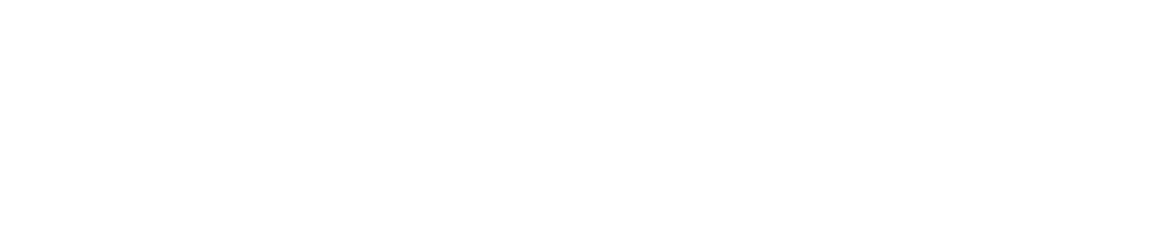


 Location: IKEA 宜家家居 敦北店 
 Data Length: 4181 
 Name:  IKEA 宜家家居 敦北店
                lat           lng     comments     is_video         likes  \
count  4.181000e+03  4.181000e+03  4181.000000  4181.000000   4181.000000   
mean   2.505280e+01  1.215486e+02     2.664195     0.032289     81.183927   
std    1.289789e-12  1.044623e-11     4.199183     0.176788    500.680852   
min    2.505280e+01  1.215486e+02     0.000000     0.000000      0.000000   
25%    2.505280e+01  1.215486e+02     0.000000     0.000000     13.000000   
50%    2.505280e+01  1.215486e+02     1.000000     0.000000     30.000000   
75%    2.505280e+01  1.215486e+02     4.000000     0.000000     62.000000   
max    2.505280e+01  1.215486e+02   112.000000     1.000000  22803.000000   

           owner_id        month  
count  4.181000e+03  4181.000000  
mean   7.147874e+08     7.354221  
std    7.744979e+08     3.206095  
min    3.038700e+04     1.000000  
25%    2.317544e+08     5.000000  
50%    3.854452e+08     8.0

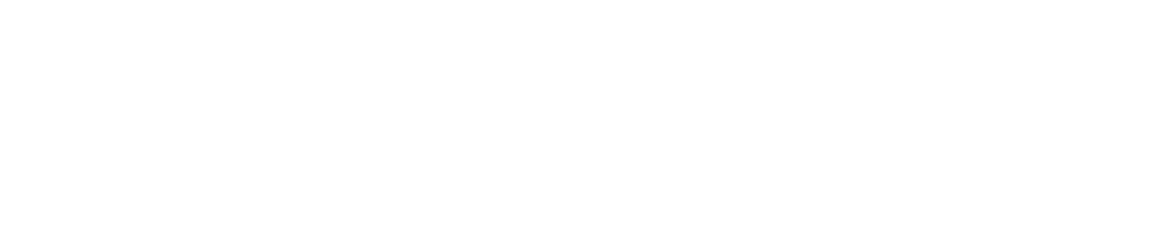


 Location: Ice Monster 
 Data Length: 4174 
 Name:  Ice Monster
                lat           lng     comments     is_video         likes  \
count  4.174000e+03  4.174000e+03  4174.000000  4174.000000   4174.000000   
mean   2.504137e+01  1.215551e+02     1.977000     0.021083     54.379732   
std    2.391263e-12  6.978366e-12     3.470384     0.143678    494.343498   
min    2.504137e+01  1.215551e+02     0.000000     0.000000      0.000000   
25%    2.504137e+01  1.215551e+02     0.000000     0.000000     10.000000   
50%    2.504137e+01  1.215551e+02     1.000000     0.000000     21.000000   
75%    2.504137e+01  1.215551e+02     3.000000     0.000000     43.750000   
max    2.504137e+01  1.215551e+02    64.000000     1.000000  25824.000000   

           owner_id        month  
count  4.174000e+03  4174.000000  
mean   9.218275e+08     7.038812  
std    9.642232e+08     2.883791  
min    1.067500e+04     1.000000  
25%    2.032600e+08     5.000000  
50%    5.011737e+08     7.00000

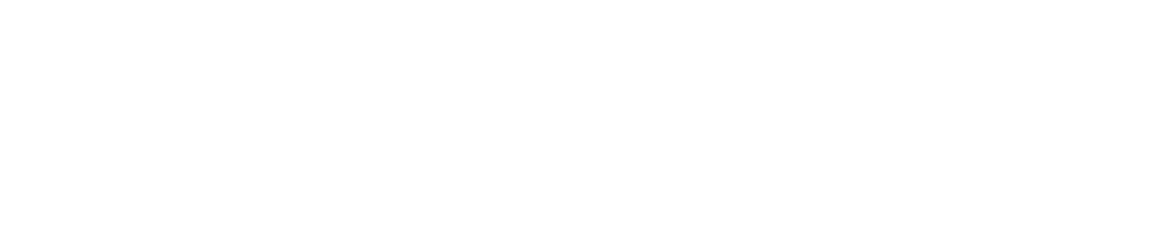


 Location: 花博公園 
 Data Length: 4151 
 Name:  花博公園
                lat           lng    comments     is_video         likes  \
count  4.151000e+03  4.151000e+03  4151.00000  4151.000000   4151.000000   
mean   2.507051e+01  1.215216e+02     1.90701     0.065045     63.673332   
std    1.407044e-12  3.538929e-12     3.97753     0.246634    391.973235   
min    2.507051e+01  1.215216e+02     0.00000     0.000000      0.000000   
25%    2.507051e+01  1.215216e+02     0.00000     0.000000      7.000000   
50%    2.507051e+01  1.215216e+02     0.00000     0.000000     20.000000   
75%    2.507051e+01  1.215216e+02     2.00000     0.000000     49.000000   
max    2.507051e+01  1.215216e+02    77.00000     1.000000  17638.000000   

           owner_id        month  
count  4.151000e+03  4151.000000  
mean   1.015975e+09     8.672609  
std    1.031964e+09     2.477857  
min    2.549600e+04     1.000000  
25%    2.384251e+08     7.000000  
50%    5.491410e+08     9.000000  
75%    1.541247e+09

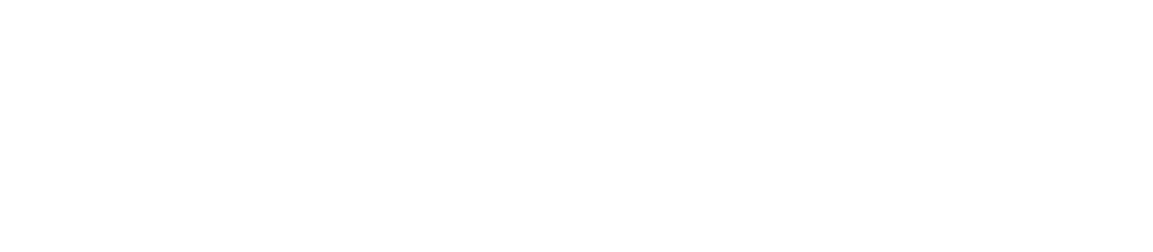


 Location: Sarabeth's Taiwan 台北敦化sogo店 
 Data Length: 4142 
 Name:  Sarabeth's Taiwan 台北敦化sogo店
                lat           lng     comments     is_video         likes  \
count  4.142000e+03  4.142000e+03  4142.000000  4142.000000   4142.000000   
mean   2.504014e+01  1.215484e+02     2.228392     0.022694     52.514727   
std    1.730380e-12  4.476960e-12     3.565780     0.148945    255.117121   
min    2.504014e+01  1.215484e+02     0.000000     0.000000      0.000000   
25%    2.504014e+01  1.215484e+02     0.000000     0.000000     11.000000   
50%    2.504014e+01  1.215484e+02     1.000000     0.000000     21.000000   
75%    2.504014e+01  1.215484e+02     3.000000     0.000000     41.000000   
max    2.504014e+01  1.215484e+02    70.000000     1.000000  10641.000000   

           owner_id        month  
count  4.142000e+03  4142.000000  
mean   7.374746e+08     7.887011  
std    9.040778e+08     1.957846  
min    1.384500e+04     5.000000  
25%    5.281079e+07     6.000000  

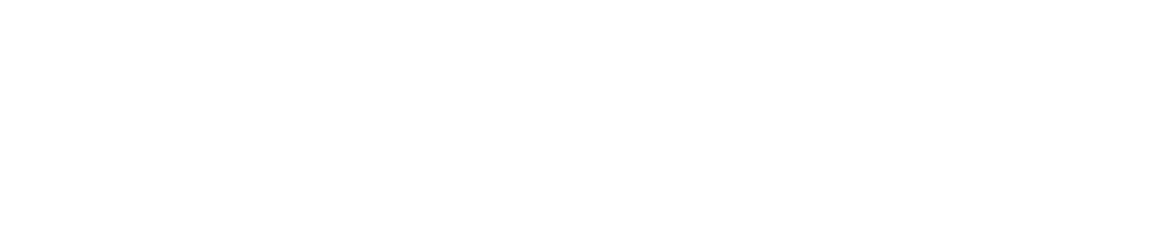


 Location: Le Méridien Taipei 台北寒舍艾美酒店 
 Data Length: 4137 
 Name:  Le Méridien Taipei 台北寒舍艾美酒店
                lat           lng     comments     is_video         likes  \
count  4.137000e+03  4.137000e+03  4137.000000  4137.000000   4137.000000   
mean   2.503808e+01  1.215683e+02     1.926275     0.039642     76.438965   
std    1.588255e-12  8.314355e-12     3.542179     0.195141    370.847444   
min    2.503808e+01  1.215683e+02     0.000000     0.000000      0.000000   
25%    2.503808e+01  1.215683e+02     0.000000     0.000000     11.000000   
50%    2.503808e+01  1.215683e+02     1.000000     0.000000     23.000000   
75%    2.503808e+01  1.215683e+02     2.000000     0.000000     49.000000   
max    2.503808e+01  1.215683e+02    65.000000     1.000000  11650.000000   

           owner_id        month  
count  4.137000e+03  4137.000000  
mean   6.966332e+08     7.171380  
std    8.606916e+08     3.550938  
min    8.260000e+03     1.000000  
25%    5.291676e+07     4.000000  

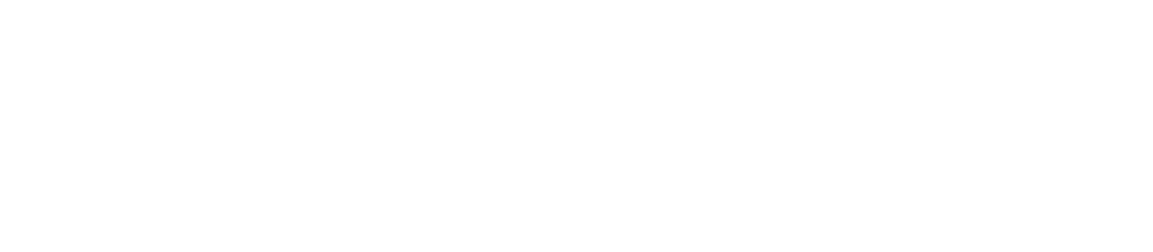


 Location: 河床工作室 -  Pâtisserie Rivière 
 Data Length: 4010 
 Name:  河床工作室 -  Pâtisserie Rivière
                lat           lng     comments   is_video        likes  \
count  4.010000e+03  4.010000e+03  4010.000000  4010.0000  4010.000000   
mean   2.503254e+01  1.215565e+02     4.093267     0.0202   161.685287   
std    1.456794e-13  4.491190e-12     5.741612     0.1407   436.264124   
min    2.503254e+01  1.215565e+02     0.000000     0.0000     0.000000   
25%    2.503254e+01  1.215565e+02     0.000000     0.0000    29.000000   
50%    2.503254e+01  1.215565e+02     2.000000     0.0000    51.000000   
75%    2.503254e+01  1.215565e+02     6.000000     0.0000    90.000000   
max    2.503254e+01  1.215565e+02    95.000000     1.0000  4551.000000   

           owner_id        month  
count  4.010000e+03  4010.000000  
mean   7.824346e+08     8.309975  
std    8.887105e+08     3.135730  
min    2.719700e+04     1.000000  
25%    2.488958e+08     7.000000  
50%    4.068290e+08     9.

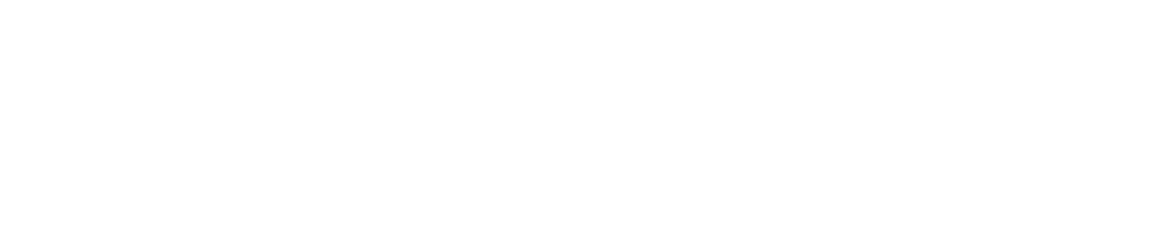


 Location: Morton's The Steakhouse - Taipei 台北莫爾頓牛排館 
 Data Length: 3856 
 Name:  Morton's The Steakhouse - Taipei 台北莫爾頓牛排館
                lat           lng     comments     is_video         likes  \
count  3.856000e+03  3.856000e+03  3856.000000  3856.000000   3856.000000   
mean   2.504039e+01  1.215668e+02     2.568465     0.016857     93.315871   
std    9.629103e-13  7.148987e-12     3.786998     0.128752    528.259931   
min    2.504039e+01  1.215668e+02     0.000000     0.000000      0.000000   
25%    2.504039e+01  1.215668e+02     0.000000     0.000000     13.000000   
50%    2.504039e+01  1.215668e+02     1.000000     0.000000     26.000000   
75%    2.504039e+01  1.215668e+02     3.000000     0.000000     53.000000   
max    2.504039e+01  1.215668e+02    38.000000     1.000000  13825.000000   

           owner_id        month  
count  3.856000e+03  3856.000000  
mean   6.486235e+08     7.027490  
std    8.281324e+08     3.369085  
min    1.763600e+04     1.000000  
25%   

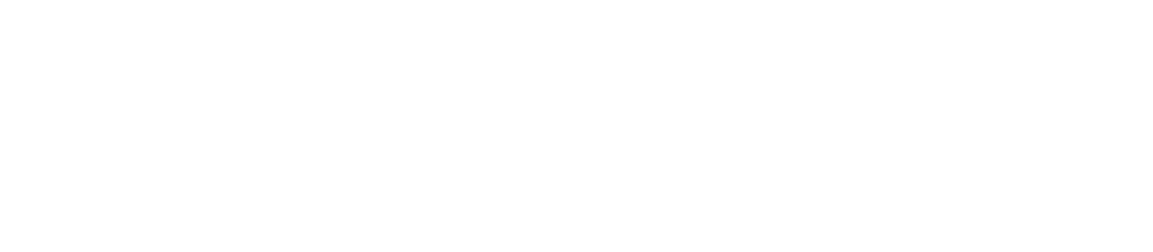


 Location: Humble House Taipei 寒舍艾麗酒店 
 Data Length: 3836 
 Name:  Humble House Taipei 寒舍艾麗酒店
                lat           lng     comments     is_video         likes  \
count  3.836000e+03  3.836000e+03  3836.000000  3836.000000   3836.000000   
mean   2.503881e+01  1.215675e+02     2.280761     0.040146     80.671794   
std    2.018204e-12  1.111434e-11     4.276817     0.196327    479.773363   
min    2.503881e+01  1.215675e+02     0.000000     0.000000      0.000000   
25%    2.503881e+01  1.215675e+02     0.000000     0.000000      9.000000   
50%    2.503881e+01  1.215675e+02     1.000000     0.000000     21.000000   
75%    2.503881e+01  1.215675e+02     3.000000     0.000000     44.000000   
max    2.503881e+01  1.215675e+02    76.000000     1.000000  16093.000000   

           owner_id        month  
count  3.836000e+03  3836.000000  
mean   7.907068e+08     7.288060  
std    9.166638e+08     3.393863  
min    2.896900e+04     1.000000  
25%    1.750969e+08     5.000000  
5

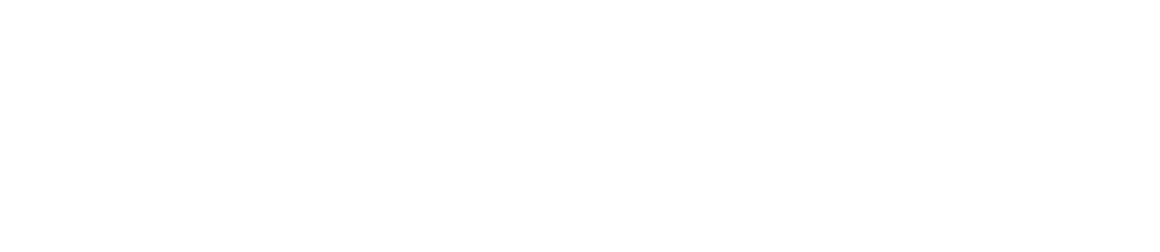


 Location: Toasteria Cafe 3號 敦南 Dunnan 
 Data Length: 3778 
 Name:  Toasteria Cafe 3號 敦南 Dunnan
                lat           lng     comments     is_video         likes  \
count  3.778000e+03  3.778000e+03  3778.000000  3778.000000   3778.000000   
mean   2.504330e+01  1.215495e+02     2.521969     0.019322    122.760455   
std    7.212963e-13  6.125689e-12     4.379674     0.137674   1196.550693   
min    2.504330e+01  1.215495e+02     0.000000     0.000000      0.000000   
25%    2.504330e+01  1.215495e+02     0.000000     0.000000     18.000000   
50%    2.504330e+01  1.215495e+02     1.000000     0.000000     34.000000   
75%    2.504330e+01  1.215495e+02     3.000000     0.000000     62.000000   
max    2.504330e+01  1.215495e+02   101.000000     1.000000  46465.000000   

           owner_id        month  
count  3.778000e+03  3778.000000  
mean   6.689965e+08     6.720487  
std    8.174647e+08     3.360395  
min    2.695100e+04     1.000000  
25%    2.015498e+08     4.000000  

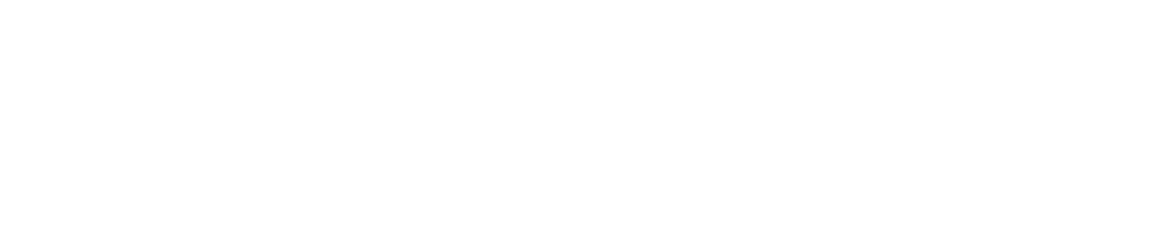


 Location: All Day Roasting Company 
 Data Length: 3679 
 Name:  All Day Roasting Company
                lat           lng     comments     is_video        likes  \
count  3.679000e+03  3.679000e+03  3679.000000  3679.000000  3679.000000   
mean   2.505667e+01  1.215602e+02     2.067681     0.014134    75.322098   
std    7.674905e-13  9.849461e-12     3.493260     0.118061   280.314337   
min    2.505667e+01  1.215602e+02     0.000000     0.000000     0.000000   
25%    2.505667e+01  1.215602e+02     0.000000     0.000000    14.000000   
50%    2.505667e+01  1.215602e+02     1.000000     0.000000    29.000000   
75%    2.505667e+01  1.215602e+02     3.000000     0.000000    57.500000   
max    2.505667e+01  1.215602e+02    46.000000     1.000000  7290.000000   

           owner_id        month  
count  3.679000e+03  3679.000000  
mean   5.351858e+08     6.748573  
std    8.044394e+08     3.295590  
min    1.102400e+04     1.000000  
25%    1.586070e+07     4.000000  
50%    2.55963

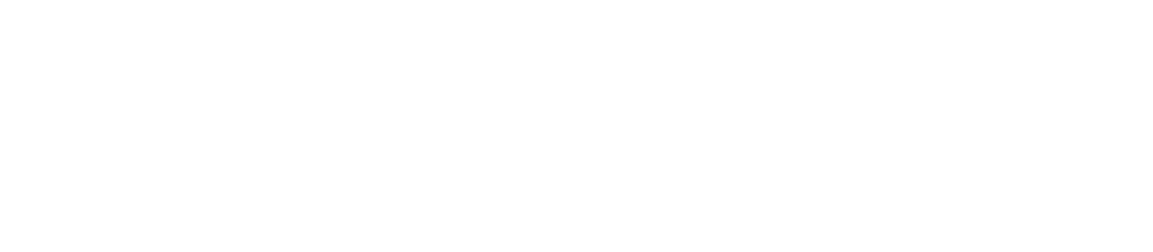


 Location: Maccha House 敦南抹茶館 
 Data Length: 3458 
 Name:  Maccha House 敦南抹茶館
                lat           lng     comments     is_video         likes  \
count  3.458000e+03  3.458000e+03  3458.000000  3458.000000   3458.000000   
mean   2.504255e+01  1.215510e+02     2.944766     0.034124     77.785136   
std    3.908550e-13  1.050334e-11     7.138987     0.181573    511.438258   
min    2.504255e+01  1.215510e+02     0.000000     0.000000      0.000000   
25%    2.504255e+01  1.215510e+02     0.000000     0.000000     18.000000   
50%    2.504255e+01  1.215510e+02     2.000000     0.000000     35.000000   
75%    2.504255e+01  1.215510e+02     4.000000     0.000000     67.000000   
max    2.504255e+01  1.215510e+02   351.000000     1.000000  22132.000000   

           owner_id        month  
count  3.458000e+03  3458.000000  
mean   8.651358e+08     6.497687  
std    8.422933e+08     3.488503  
min    2.449100e+04     1.000000  
25%    2.998225e+08     4.000000  
50%    5.208987e+

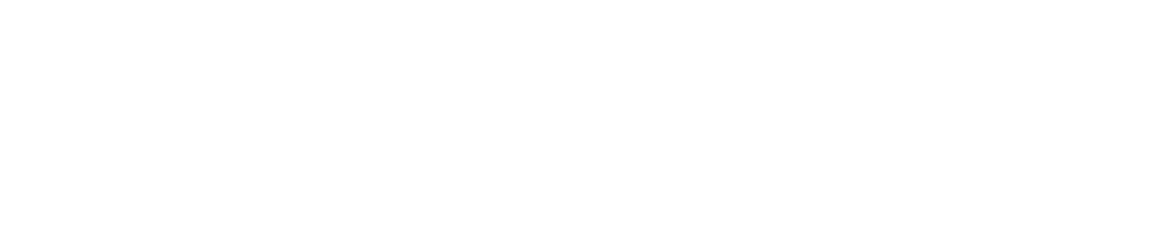


 Location: WAVE CLUB Taipei 
 Data Length: 3431 
 Name:  WAVE CLUB Taipei
                lat           lng     comments     is_video         likes  \
count  3.431000e+03  3.431000e+03  3431.000000  3431.000000   3431.000000   
mean   2.503502e+01  1.215662e+02     4.292626     0.176916     87.293500   
std    1.250737e-12  7.959239e-13     5.200365     0.381654    319.534538   
min    2.503502e+01  1.215662e+02     0.000000     0.000000      0.000000   
25%    2.503502e+01  1.215662e+02     0.000000     0.000000     27.000000   
50%    2.503502e+01  1.215662e+02     3.000000     0.000000     51.000000   
75%    2.503502e+01  1.215662e+02     6.000000     0.000000     89.000000   
max    2.503502e+01  1.215662e+02    44.000000     1.000000  13171.000000   

           owner_id        month  
count  3.431000e+03  3431.000000  
mean   7.978723e+08     7.503352  
std    7.000743e+08     3.248938  
min    2.751300e+04     1.000000  
25%    2.989415e+08     5.000000  
50%    5.208794e+08  

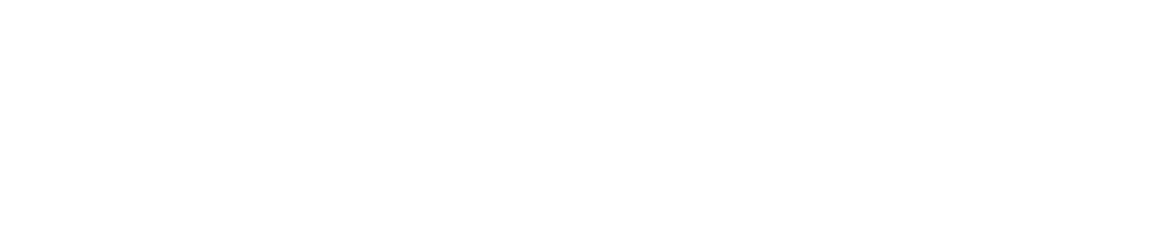


 Location: MUME 
 Data Length: 3256 
 Name:  MUME
                lat           lng     comments     is_video         likes  \
count  3.256000e+03  3.256000e+03  3256.000000  3256.000000   3256.000000   
mean   2.503619e+01  1.215481e+02     1.761671     0.016585    105.898956   
std    8.243562e-13  9.096344e-13     3.254351     0.127729    929.273068   
min    2.503619e+01  1.215481e+02     0.000000     0.000000      0.000000   
25%    2.503619e+01  1.215481e+02     0.000000     0.000000     13.000000   
50%    2.503619e+01  1.215481e+02     1.000000     0.000000     27.000000   
75%    2.503619e+01  1.215481e+02     2.000000     0.000000     57.250000   
max    2.503619e+01  1.215481e+02    58.000000     1.000000  37448.000000   

           owner_id        month  
count  3.256000e+03  3256.000000  
mean   6.210097e+08     7.041769  
std    9.103422e+08     3.335529  
min    1.550000e+03     1.000000  
25%    2.053824e+07     4.000000  
50%    2.295637e+08     7.000000  
75%    7.9

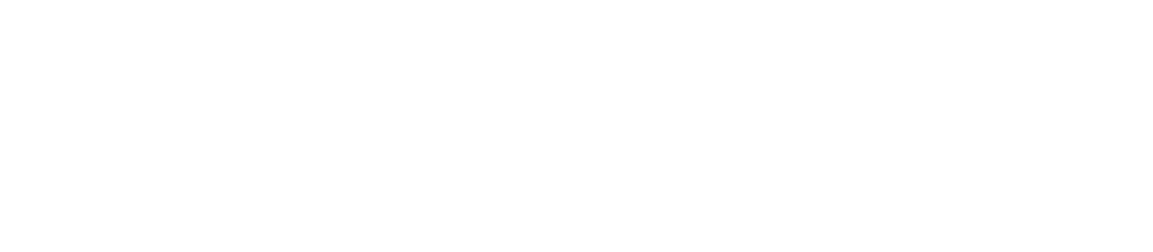


 Location: 台北小巨蛋 如果 田馥甄巡迴演唱會 
 Data Length: 3130 
 Name:  台北小巨蛋 如果 田馥甄巡迴演唱會
                lat           lng     comments     is_video         likes  \
count  3.130000e+03  3.130000e+03  3130.000000  3130.000000   3130.000000   
mean   2.505085e+01  1.215498e+02     2.196805     0.192332    109.568051   
std    1.204562e-12  4.960381e-12     4.343393     0.394196   1016.454016   
min    2.505085e+01  1.215498e+02     0.000000     0.000000      0.000000   
25%    2.505085e+01  1.215498e+02     0.000000     0.000000     18.000000   
50%    2.505085e+01  1.215498e+02     1.000000     0.000000     32.000000   
75%    2.505085e+01  1.215498e+02     3.000000     0.000000     55.750000   
max    2.505085e+01  1.215498e+02   146.000000     1.000000  30766.000000   

           owner_id        month  
count  3.130000e+03  3130.000000  
mean   7.789850e+08    11.998722  
std    8.995569e+08     0.071497  
min    1.384500e+04     8.000000  
25%    2.350203e+08    12.000000  
50%    3.795740e+08

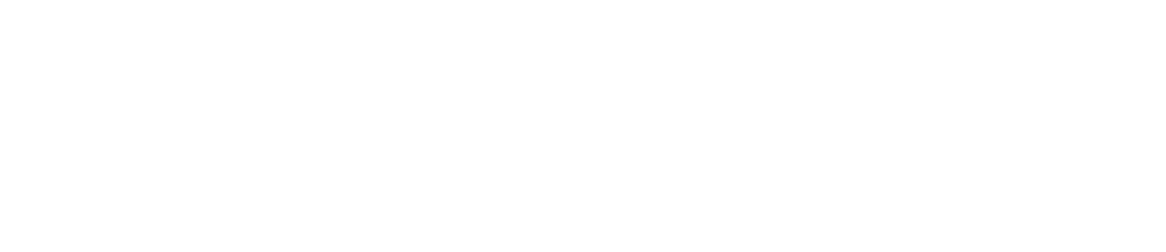


 Location: 饒河街觀光夜巿 Raohe Street Night Market 
 Data Length: 3117 
 Name:  饒河街觀光夜巿 Raohe Street Night Market
                lat           lng     comments     is_video        likes  \
count  3.117000e+03  3.117000e+03  3117.000000  3117.000000  3117.000000   
mean   2.505043e+01  1.215753e+02     1.954764     0.065768    48.908245   
std    2.274102e-13  3.297447e-12     5.239716     0.247917   171.374720   
min    2.505043e+01  1.215753e+02     0.000000     0.000000     0.000000   
25%    2.505043e+01  1.215753e+02     0.000000     0.000000    11.000000   
50%    2.505043e+01  1.215753e+02     1.000000     0.000000    24.000000   
75%    2.505043e+01  1.215753e+02     2.000000     0.000000    49.000000   
max    2.505043e+01  1.215753e+02   137.000000     1.000000  6531.000000   

           owner_id        month  
count  3.117000e+03  3117.000000  
mean   7.921099e+08     9.026949  
std    1.004640e+09     3.084587  
min    2.549600e+04     1.000000  
25%    4.020737e+07     7.00000

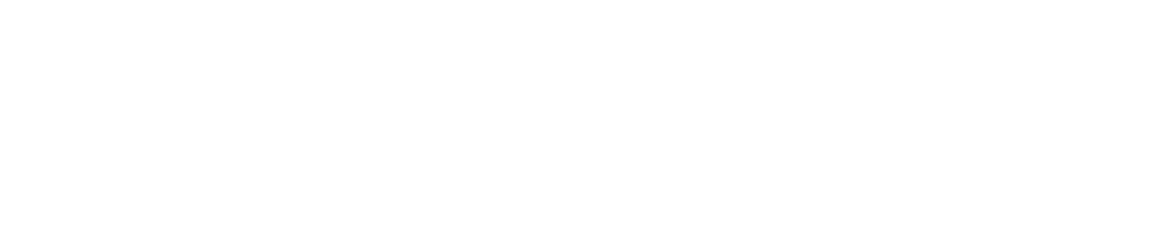


 Location: 美麗華百樂園 
 Data Length: 3112 
 Name:  美麗華百樂園
                lat           lng     comments     is_video        likes  \
count  3.112000e+03  3.112000e+03  3112.000000  3112.000000  3112.000000   
mean   2.508321e+01  1.215575e+02     1.834190     0.071015    43.914846   
std    3.304555e-13  3.681203e-12     3.243491     0.256892   159.848772   
min    2.508321e+01  1.215575e+02     0.000000     0.000000     0.000000   
25%    2.508321e+01  1.215575e+02     0.000000     0.000000     7.750000   
50%    2.508321e+01  1.215575e+02     0.000000     0.000000    20.000000   
75%    2.508321e+01  1.215575e+02     2.000000     0.000000    46.000000   
max    2.508321e+01  1.215575e+02    51.000000     1.000000  5135.000000   

           owner_id        month  
count  3.112000e+03  3112.000000  
mean   1.150108e+09    10.603149  
std    1.073398e+09     1.551110  
min    1.305000e+04     1.000000  
25%    3.007326e+08    10.000000  
50%    7.814076e+08    11.000000  
75%    1.664634

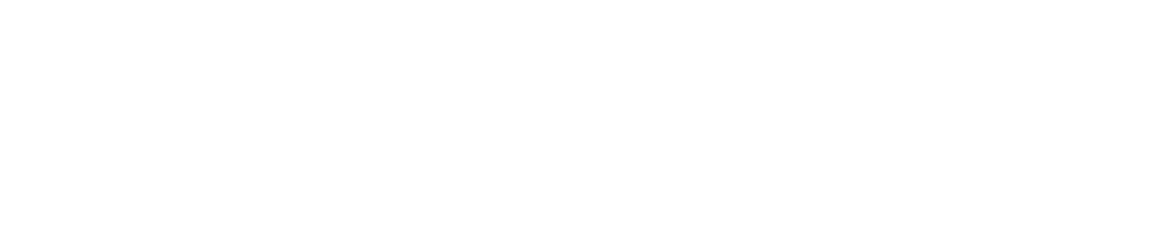


 Location: TORUK - The First Flight 
 Data Length: 3110 
 Name:  TORUK - The First Flight
                lat           lng     comments     is_video        likes  \
count  3.110000e+03  3.110000e+03  3110.000000  3110.000000  3110.000000   
mean   2.505194e+01  1.215514e+02     1.109968     0.205466    35.025723   
std    1.172584e-12  1.321822e-12     3.823308     0.404107    87.582117   
min    2.505194e+01  1.215514e+02     0.000000     0.000000     0.000000   
25%    2.505194e+01  1.215514e+02     0.000000     0.000000     8.000000   
50%    2.505194e+01  1.215514e+02     0.000000     0.000000    16.000000   
75%    2.505194e+01  1.215514e+02     1.000000     0.000000    31.000000   
max    2.505194e+01  1.215514e+02   166.000000     1.000000  2273.000000   

           owner_id        month  
count  3.110000e+03  3110.000000  
mean   6.209447e+08     8.376527  
std    9.054643e+08     2.736180  
min    5.117000e+04     3.000000  
25%    3.179548e+07     6.000000  
50%    2.18701

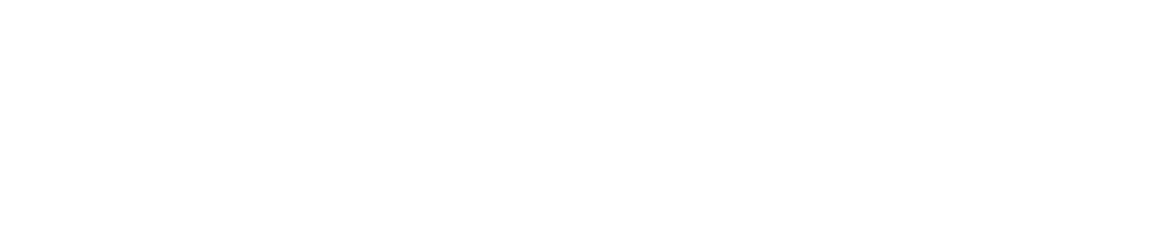


 Location: 韓國第一品牌 八色烤肉 
 Data Length: 3078 
 Name:  韓國第一品牌 八色烤肉
                lat           lng     comments     is_video         likes  \
count  3.078000e+03  3.078000e+03  3078.000000  3078.000000   3078.000000   
mean   2.504216e+01  1.215533e+02     3.129955     0.085120     87.259909   
std    1.307611e-12  6.779679e-12     4.045806     0.279106   1196.544103   
min    2.504216e+01  1.215533e+02     0.000000     0.000000      0.000000   
25%    2.504216e+01  1.215533e+02     0.000000     0.000000     14.000000   
50%    2.504216e+01  1.215533e+02     2.000000     0.000000     29.000000   
75%    2.504216e+01  1.215533e+02     4.000000     0.000000     56.000000   
max    2.504216e+01  1.215533e+02    37.000000     1.000000  46203.000000   

           owner_id        month  
count  3.078000e+03  3078.000000  
mean   7.591282e+08     6.208902  
std    7.744979e+08     3.317589  
min    4.570000e+02     1.000000  
25%    2.759325e+08     3.000000  
50%    4.554546e+08     6.00000

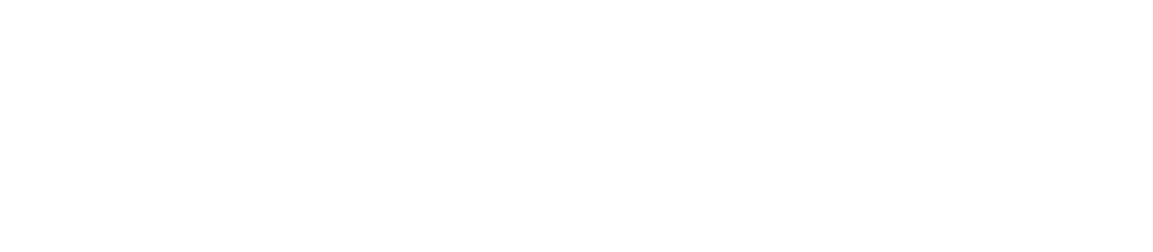


 Location: Zhongshan District, Taipei 
 Data Length: 3032 
 Name:  Zhongshan District, Taipei
                lat           lng     comments     is_video          likes  \
count  3.032000e+03  3.032000e+03  3032.000000  3032.000000    3032.000000   
mean   2.506889e+01  1.215331e+02     1.950858     0.049142     104.953826   
std    7.675127e-13  7.675127e-13     5.828566     0.216201    2725.589262   
min    2.506889e+01  1.215331e+02     0.000000     0.000000       0.000000   
25%    2.506889e+01  1.215331e+02     0.000000     0.000000       9.000000   
50%    2.506889e+01  1.215331e+02     0.000000     0.000000      21.000000   
75%    2.506889e+01  1.215331e+02     2.000000     0.000000      45.000000   
max    2.506889e+01  1.215331e+02   239.000000     1.000000  149826.000000   

           owner_id        month  
count  3.032000e+03  3032.000000  
mean   1.174569e+09     9.817612  
std    1.284411e+09     2.716334  
min    1.726000e+03     1.000000  
25%    5.511438e+07    10.0

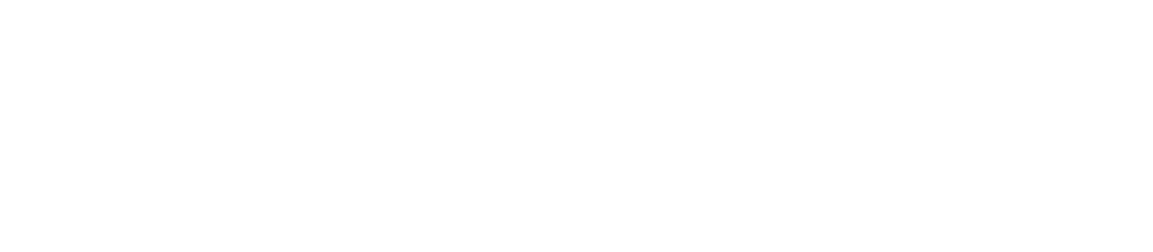


 Location: 美好年代 Belle Époque 
 Data Length: 3031 
 Name:  美好年代 Belle Époque
                lat           lng     comments     is_video         likes  \
count  3.031000e+03  3.031000e+03  3031.000000  3031.000000   3031.000000   
mean   2.504318e+01  1.215457e+02     3.046519     0.013197    123.934675   
std    1.659391e-12  2.714721e-12     4.494971     0.114136   1071.061465   
min    2.504318e+01  1.215457e+02     0.000000     0.000000      0.000000   
25%    2.504318e+01  1.215457e+02     0.000000     0.000000     18.000000   
50%    2.504318e+01  1.215457e+02     2.000000     0.000000     38.000000   
75%    2.504318e+01  1.215457e+02     4.000000     0.000000     69.000000   
max    2.504318e+01  1.215457e+02    99.000000     1.000000  38853.000000   

           owner_id        month  
count  3.031000e+03  3031.000000  
mean   8.278605e+08     6.699439  
std    8.635808e+08     3.538715  
min    3.803000e+03     1.000000  
25%    2.471367e+08     4.000000  
50%    4.786363e+08

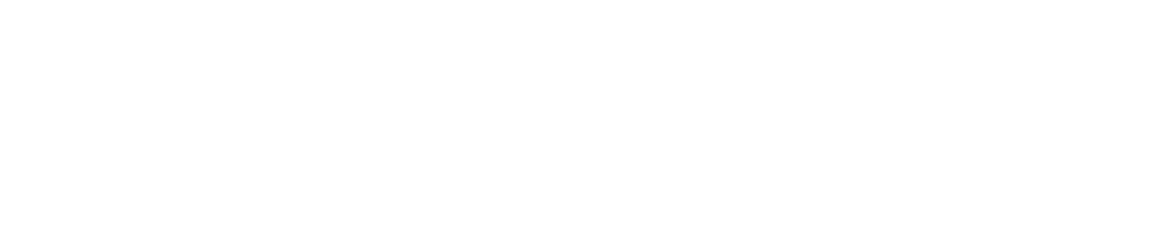


 Location: 誠品生活松菸店 
 Data Length: 3005 
 Name:  誠品生活松菸店
                lat           lng     comments     is_video         likes  \
count  3.005000e+03  3.005000e+03  3005.000000  3005.000000   3005.000000   
mean   2.504400e+01  1.215613e+02     2.157404     0.038270     94.065557   
std    8.385800e-13  6.111685e-12     4.775748     0.191878    993.317642   
min    2.504400e+01  1.215613e+02     0.000000     0.000000      0.000000   
25%    2.504400e+01  1.215613e+02     0.000000     0.000000      9.000000   
50%    2.504400e+01  1.215613e+02     1.000000     0.000000     24.000000   
75%    2.504400e+01  1.215613e+02     3.000000     0.000000     50.000000   
max    2.504400e+01  1.215613e+02   105.000000     1.000000  34291.000000   

           owner_id        month  
count  3.005000e+03  3005.000000  
mean   8.564065e+08     6.990682  
std    9.873814e+08     3.396253  
min    1.517700e+04     1.000000  
25%    1.847652e+08     4.000000  
50%    3.797577e+08     8.000000  
75% 

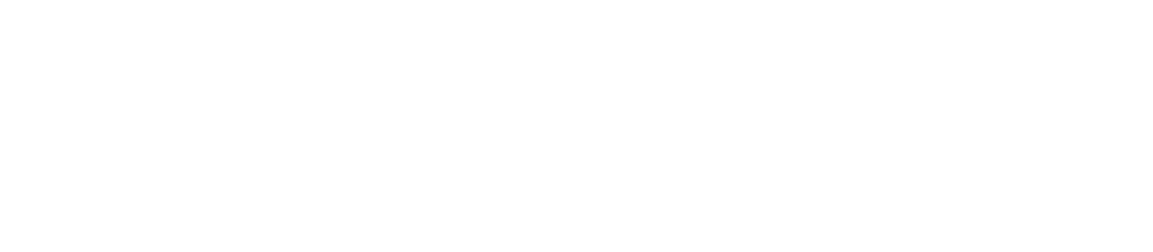


 Location: Chimac175 Taipei 
 Data Length: 2973 
 Name:  Chimac175 Taipei
                lat           lng     comments     is_video         likes  \
count  2.973000e+03  2.973000e+03  2973.000000  2973.000000   2973.000000   
mean   2.503834e+01  1.215549e+02     3.465187     0.017827     99.199798   
std    3.553311e-14  6.324894e-12     5.301021     0.132345    943.002886   
min    2.503834e+01  1.215549e+02     0.000000     0.000000      0.000000   
25%    2.503834e+01  1.215549e+02     0.000000     0.000000     23.000000   
50%    2.503834e+01  1.215549e+02     2.000000     0.000000     43.000000   
75%    2.503834e+01  1.215549e+02     5.000000     0.000000     78.000000   
max    2.503834e+01  1.215549e+02   186.000000     1.000000  48406.000000   

           owner_id        month  
count  2.973000e+03  2973.000000  
mean   6.868229e+08     6.247225  
std    7.632870e+08     3.204939  
min    2.444500e+04     1.000000  
25%    2.494877e+08     4.000000  
50%    3.856643e+08  

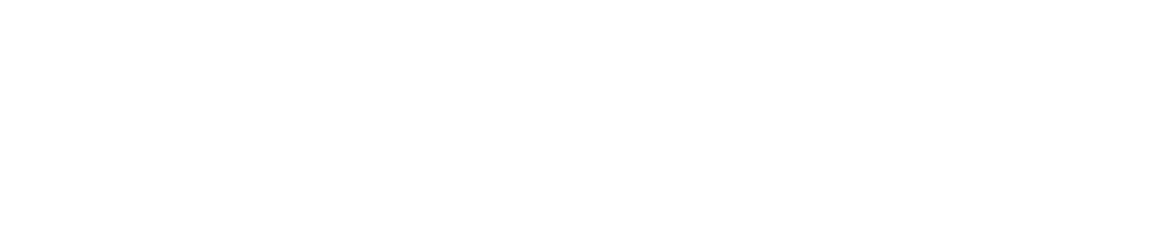


 Location: 國賓影城＠台北長春廣場 
 Data Length: 2946 
 Name:  國賓影城＠台北長春廣場
                lat           lng     comments     is_video         likes  \
count  2.946000e+03  2.946000e+03  2946.000000  2946.000000   2946.000000   
mean   2.505468e+01  1.215341e+02     2.775628     0.013578     81.571283   
std    7.852830e-13  3.780729e-12     5.018766     0.115749   1111.981830   
min    2.505468e+01  1.215341e+02     0.000000     0.000000      0.000000   
25%    2.505468e+01  1.215341e+02     0.000000     0.000000     10.000000   
50%    2.505468e+01  1.215341e+02     1.000000     0.000000     21.000000   
75%    2.505468e+01  1.215341e+02     4.000000     0.000000     42.750000   
max    2.505468e+01  1.215341e+02   147.000000     1.000000  41149.000000   

           owner_id        month  
count  2.946000e+03  2946.000000  
mean   8.107524e+08     7.346572  
std    8.535747e+08     3.312125  
min    2.324900e+04     1.000000  
25%    2.229436e+08     5.000000  
50%    4.678694e+08     8.00000

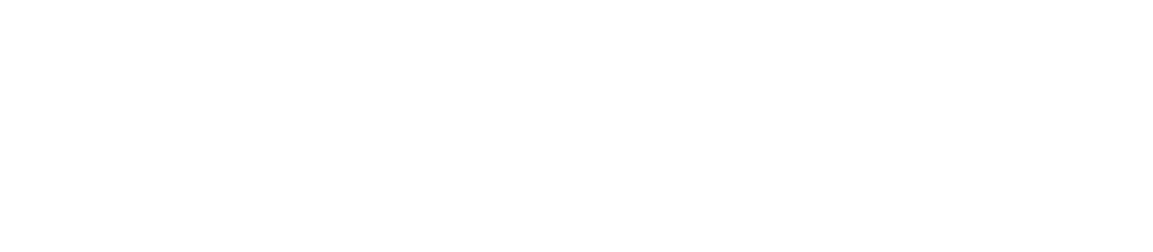


 Location: Drip Cafe 好滴 松菸店 
 Data Length: 2760 
 Name:  Drip Cafe 好滴 松菸店
                lat           lng     comments     is_video        likes  \
count  2.760000e+03  2.760000e+03  2760.000000  2760.000000  2760.000000   
mean   2.504357e+01  1.215625e+02     2.555435     0.014855    49.624275   
std    7.355450e-13  1.691398e-12     3.581066     0.120995   104.920117   
min    2.504357e+01  1.215625e+02     0.000000     0.000000     0.000000   
25%    2.504357e+01  1.215625e+02     0.000000     0.000000    14.000000   
50%    2.504357e+01  1.215625e+02     1.000000     0.000000    28.500000   
75%    2.504357e+01  1.215625e+02     4.000000     0.000000    55.000000   
max    2.504357e+01  1.215625e+02    61.000000     1.000000  2647.000000   

           owner_id        month  
count  2.760000e+03  2760.000000  
mean   7.376165e+08     6.486957  
std    8.212109e+08     3.499782  
min    1.080200e+04     1.000000  
25%    2.376855e+08     4.000000  
50%    4.070110e+08     7.0000

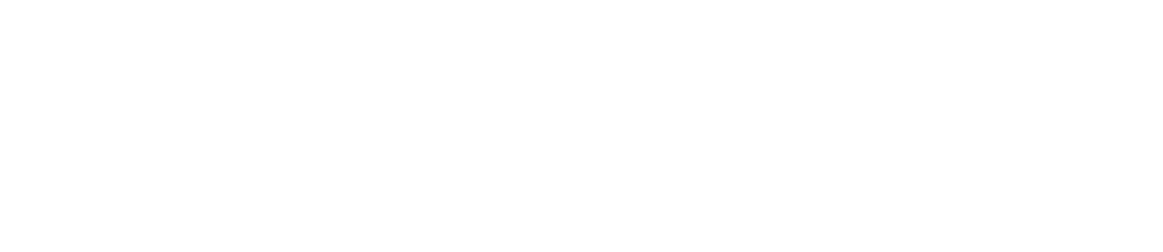


 Location: 好丘Good Cho's 信義店 -四四南村 
 Data Length: 2741 
 Name:  好丘Good Cho's 信義店 -四四南村
                lat           lng     comments     is_video        likes  \
count  2.741000e+03  2.741000e+03  2741.000000  2741.000000  2741.000000   
mean   2.503190e+01  1.215621e+02     1.877782     0.009121    54.234221   
std    8.954472e-13  4.093473e-12     4.845498     0.095083   240.432493   
min    2.503190e+01  1.215621e+02     0.000000     0.000000     0.000000   
25%    2.503190e+01  1.215621e+02     0.000000     0.000000    11.000000   
50%    2.503190e+01  1.215621e+02     0.000000     0.000000    24.000000   
75%    2.503190e+01  1.215621e+02     2.000000     0.000000    48.000000   
max    2.503190e+01  1.215621e+02   160.000000     1.000000  7361.000000   

           owner_id        month  
count  2.741000e+03  2741.000000  
mean   8.381850e+08     7.032105  
std    9.732536e+08     3.445465  
min    1.325100e+04     1.000000  
25%    5.584219e+07     4.000000  
50%    4.010607e+0

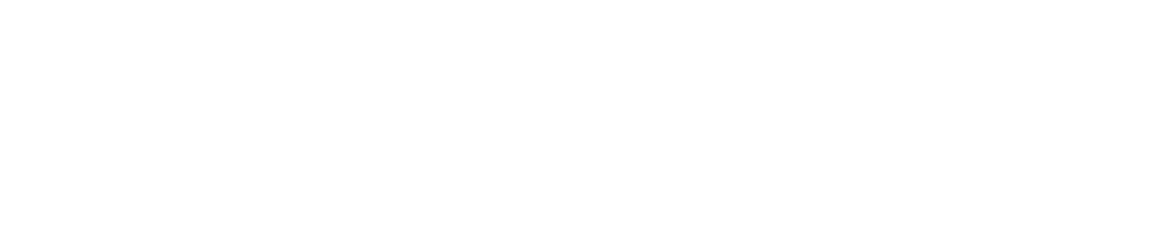


 Location: Street Churros Taiwan 
 Data Length: 2731 
 Name:  Street Churros Taiwan
               lat          lng     comments     is_video         likes  \
count  2731.000000  2731.000000  2731.000000  2731.000000   2731.000000   
mean     25.039958   121.559593     2.522885     0.011351     84.656902   
std       0.000633     0.004955     3.410462     0.105955    769.294174   
min      25.038960   121.556450     0.000000     0.000000      0.000000   
25%      25.038960   121.556450     0.000000     0.000000     19.000000   
50%      25.040360   121.556450     2.000000     0.000000     37.000000   
75%      25.040360   121.567400     4.000000     0.000000     69.000000   
max      25.040360   121.567400    32.000000     1.000000  36730.000000   

           owner_id        month  
count  2.731000e+03  2731.000000  
mean   8.196992e+08    11.298425  
std    9.189501e+08     0.775963  
min    1.570700e+04     7.000000  
25%    2.461277e+08    11.000000  
50%    4.252680e+08    11.000

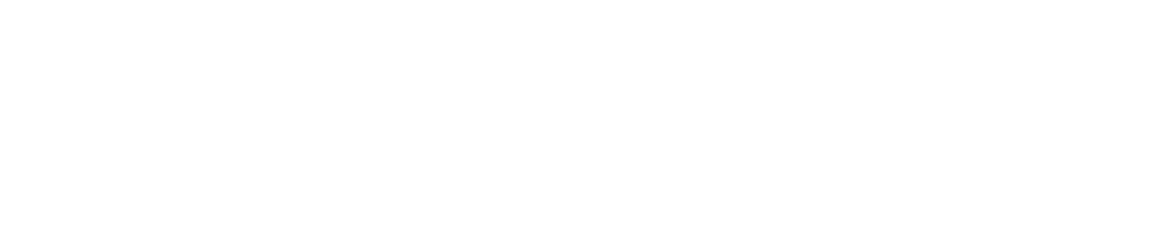


 Location: Din Tai Fung @ Taipei 101 
 Data Length: 2713 
 Name:  Din Tai Fung @ Taipei 101
                lat           lng     comments    is_video        likes  \
count  2.713000e+03  2.713000e+03  2713.000000  2713.00000  2713.000000   
mean   2.503340e+01  1.215643e+02     1.834869     0.08146    49.581644   
std    2.700560e-13  1.847752e-12     3.303481     0.27359   216.338318   
min    2.503340e+01  1.215643e+02     0.000000     0.00000     0.000000   
25%    2.503340e+01  1.215643e+02     0.000000     0.00000     9.000000   
50%    2.503340e+01  1.215643e+02     1.000000     0.00000    20.000000   
75%    2.503340e+01  1.215643e+02     2.000000     0.00000    38.000000   
max    2.503340e+01  1.215643e+02    67.000000     1.00000  5286.000000   

           owner_id        month  
count  2.713000e+03  2713.000000  
mean   7.286587e+08     7.413933  
std    9.773956e+08     3.606275  
min    1.920000e+02     1.000000  
25%    2.744457e+07     4.000000  
50%    2.565084e+08  

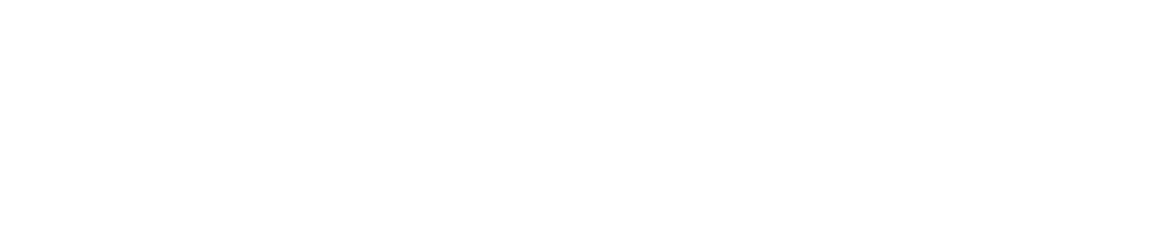


 Location: HoneyPig 
 Data Length: 2700 
 Name:  HoneyPig
                lat           lng     comments     is_video        likes  \
count  2.700000e+03  2.700000e+03  2700.000000  2700.000000  2700.000000   
mean   2.503300e+01  1.215596e+02     2.447037     0.071111    55.675926   
std    7.675283e-13  5.628541e-12     3.380053     0.257058   180.695888   
min    2.503300e+01  1.215596e+02     0.000000     0.000000     0.000000   
25%    2.503300e+01  1.215596e+02     0.000000     0.000000    14.000000   
50%    2.503300e+01  1.215596e+02     1.000000     0.000000    28.000000   
75%    2.503300e+01  1.215596e+02     4.000000     0.000000    53.000000   
max    2.503300e+01  1.215596e+02    37.000000     1.000000  4830.000000   

           owner_id        month  
count  2.700000e+03  2700.000000  
mean   6.991138e+08     6.634815  
std    7.615217e+08     3.473924  
min    1.384500e+04     1.000000  
25%    2.393507e+08     4.000000  
50%    3.859124e+08     6.000000  
75%    1.06

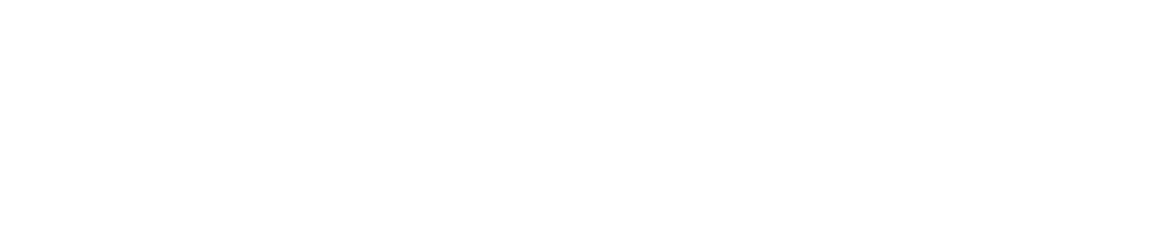


 Location: 橘色涮涮屋 
 Data Length: 2617 
 Name:  橘色涮涮屋
                lat           lng     comments     is_video         likes  \
count  2.617000e+03  2.617000e+03  2617.000000  2617.000000   2617.000000   
mean   2.503868e+01  1.215462e+02     2.407719     0.047382    104.477264   
std    7.710862e-13  7.206280e-12     3.707066     0.212496    795.365264   
min    2.503868e+01  1.215462e+02     0.000000     0.000000      0.000000   
25%    2.503868e+01  1.215462e+02     0.000000     0.000000     15.000000   
50%    2.503868e+01  1.215462e+02     1.000000     0.000000     31.000000   
75%    2.503868e+01  1.215462e+02     3.000000     0.000000     60.000000   
max    2.503868e+01  1.215462e+02    54.000000     1.000000  30196.000000   

           owner_id        month  
count  2.617000e+03  2617.000000  
mean   5.834282e+08     7.112342  
std    7.550338e+08     3.306060  
min    2.466300e+04     1.000000  
25%    1.831307e+08     4.000000  
50%    3.107779e+08     7.000000  
75%    5

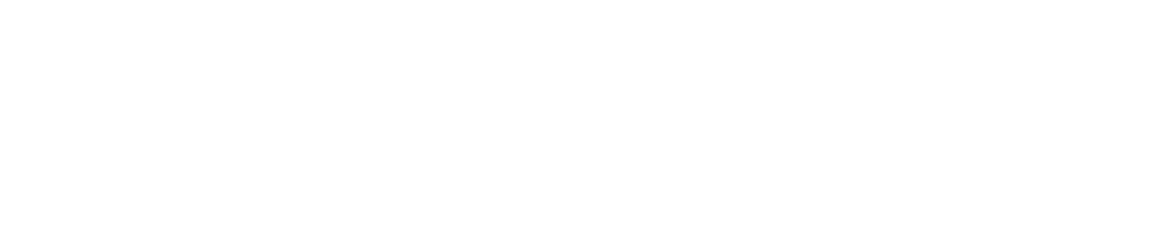


 Location: 舒服生活 Truffles Living 
 Data Length: 2610 
 Name:  舒服生活 Truffles Living
                lat           lng     comments     is_video         likes  \
count  2.610000e+03  2.610000e+03  2610.000000  2610.000000   2610.000000   
mean   2.503271e+01  1.215509e+02     1.784674     0.010728     94.519540   
std    4.193005e-13  3.354404e-12     3.165366     0.103039    812.614919   
min    2.503271e+01  1.215509e+02     0.000000     0.000000      0.000000   
25%    2.503271e+01  1.215509e+02     0.000000     0.000000     16.000000   
50%    2.503271e+01  1.215509e+02     0.000000     0.000000     28.000000   
75%    2.503271e+01  1.215509e+02     2.000000     0.000000     60.000000   
max    2.503271e+01  1.215509e+02    49.000000     1.000000  38718.000000   

           owner_id        month  
count  2.610000e+03  2610.000000  
mean   8.205394e+08     6.387356  
std    9.021715e+08     3.462850  
min    2.324900e+04     1.000000  
25%    1.984628e+08     3.000000  
50%    3.5594

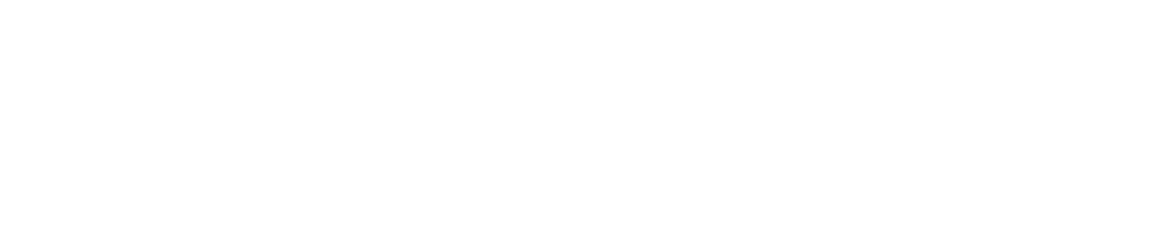


 Location: Milkglider Latteartist Unity 
 Data Length: 2572 
 Name:  Milkglider Latteartist Unity
                lat           lng     comments     is_video        likes  \
count  2.572000e+03  2.572000e+03  2572.000000  2572.000000  2572.000000   
mean   2.505944e+01  1.215487e+02     2.862364     0.202177   172.262442   
std    4.477290e-13  2.672160e-12     4.366668     0.401702   216.103809   
min    2.505944e+01  1.215487e+02     0.000000     0.000000     0.000000   
25%    2.505944e+01  1.215487e+02     0.000000     0.000000    24.000000   
50%    2.505944e+01  1.215487e+02     2.000000     0.000000    71.000000   
75%    2.505944e+01  1.215487e+02     4.000000     0.000000   273.000000   
max    2.505944e+01  1.215487e+02    88.000000     1.000000  2943.000000   

           owner_id        month  
count  2.572000e+03  2572.000000  
mean   7.824346e+08     6.145412  
std    8.255072e+08     3.191881  
min    1.418500e+04     1.000000  
25%    2.223712e+08     4.000000  
50%   

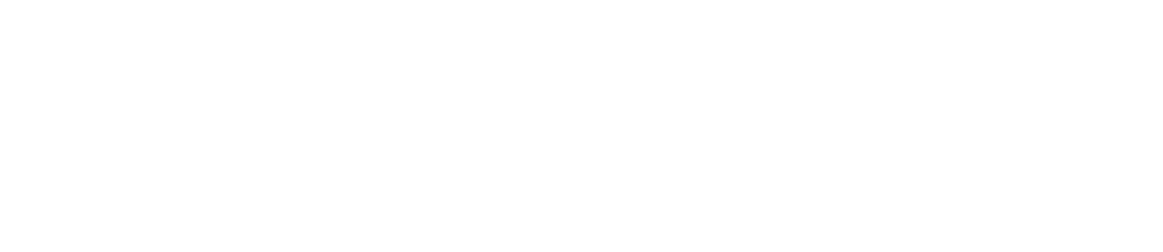


 Location: 三一Bloom 
 Data Length: 2497 
 Name:  三一Bloom
                lat           lng     comments     is_video        likes  \
count  2.497000e+03  2.497000e+03  2497.000000  2497.000000  2497.000000   
mean   2.504098e+01  1.215448e+02     2.452543     0.002002    86.651181   
std    6.111891e-13  6.680440e-13     6.242836     0.044712   248.247122   
min    2.504098e+01  1.215448e+02     0.000000     0.000000     0.000000   
25%    2.504098e+01  1.215448e+02     0.000000     0.000000    21.000000   
50%    2.504098e+01  1.215448e+02     1.000000     0.000000    40.000000   
75%    2.504098e+01  1.215448e+02     3.000000     0.000000    79.000000   
max    2.504098e+01  1.215448e+02   256.000000     1.000000  7770.000000   

           owner_id        month  
count  2.497000e+03  2497.000000  
mean   6.702799e+08     5.823388  
std    7.936928e+08     1.283699  
min    1.319900e+04     1.000000  
25%    1.929246e+08     5.000000  
50%    3.470311e+08     6.000000  
75%    9.6475

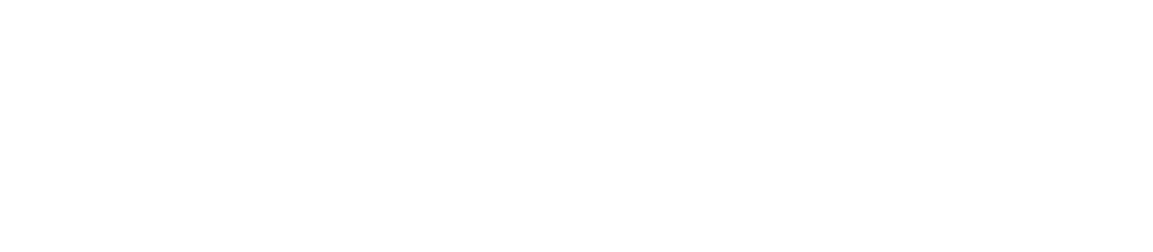


 Location: 叁和院 台灣風格飲食 參和院 
 Data Length: 2485 
 Name:  叁和院 台灣風格飲食 參和院
                lat           lng     comments     is_video        likes  \
count  2.485000e+03  2.485000e+03  2485.000000  2485.000000  2485.000000   
mean   2.504227e+01  1.215480e+02     2.378270     0.016499    76.565795   
std    1.108670e-12  2.572682e-12     3.906744     0.127410   340.466647   
min    2.504227e+01  1.215480e+02     0.000000     0.000000     0.000000   
25%    2.504227e+01  1.215480e+02     0.000000     0.000000    14.000000   
50%    2.504227e+01  1.215480e+02     1.000000     0.000000    29.000000   
75%    2.504227e+01  1.215480e+02     3.000000     0.000000    57.000000   
max    2.504227e+01  1.215480e+02    67.000000     1.000000  6006.000000   

           owner_id        month  
count  2.485000e+03  2485.000000  
mean   7.311029e+08     7.180684  
std    8.786856e+08     3.299824  
min    5.845700e+04     1.000000  
25%    2.158213e+08     5.000000  
50%    3.635886e+08     8.000000  

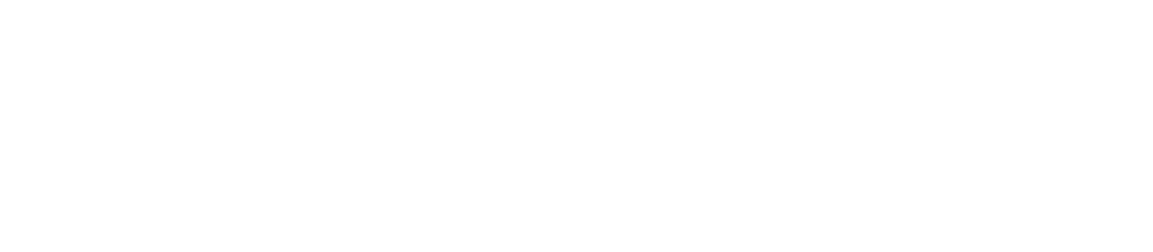


 Location: Taipei Songshan Airport 
 Data Length: 2474 
 Name:  Taipei Songshan Airport
                lat           lng     comments     is_video         likes  \
count  2.474000e+03  2.474000e+03  2474.000000  2474.000000   2474.000000   
mean   2.506944e+01  1.215517e+02     2.544058     0.074373     73.466047   
std    8.670374e-13  1.222381e-12     5.228762     0.262431    429.733130   
min    2.506944e+01  1.215517e+02     0.000000     0.000000      0.000000   
25%    2.506944e+01  1.215517e+02     0.000000     0.000000      9.000000   
50%    2.506944e+01  1.215517e+02     1.000000     0.000000     23.000000   
75%    2.506944e+01  1.215517e+02     3.000000     0.000000     52.000000   
max    2.506944e+01  1.215517e+02   109.000000     1.000000  14197.000000   

           owner_id        month  
count  2.474000e+03  2474.000000  
mean   9.120360e+08     7.511318  
std    9.653639e+08     3.591234  
min    1.126600e+04     1.000000  
25%    2.185642e+08     4.250000  
50%    

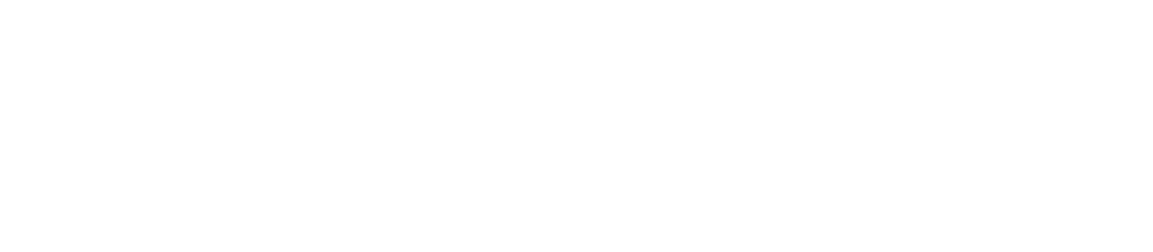


 Location: 京華城 
 Data Length: 2466 
 Name:  京華城
                lat           lng     comments     is_video         likes  \
count  2.466000e+03  2.466000e+03  2466.000000  2466.000000   2466.000000   
mean   2.504796e+01  1.215622e+02     2.435929     0.070154     67.015410   
std    4.583930e-13  1.165526e-12    15.441631     0.255458    379.330567   
min    2.504796e+01  1.215622e+02     0.000000     0.000000      0.000000   
25%    2.504796e+01  1.215622e+02     0.000000     0.000000      8.000000   
50%    2.504796e+01  1.215622e+02     1.000000     0.000000     19.000000   
75%    2.504796e+01  1.215622e+02     3.000000     0.000000     47.000000   
max    2.504796e+01  1.215622e+02   745.000000     1.000000  15285.000000   

           owner_id        month  
count  2.466000e+03  2466.000000  
mean   1.024641e+09     7.556772  
std    9.931658e+08     3.338907  
min    1.756900e+04     1.000000  
25%    2.776248e+08     5.000000  
50%    5.894631e+08     8.000000  
75%    1.549

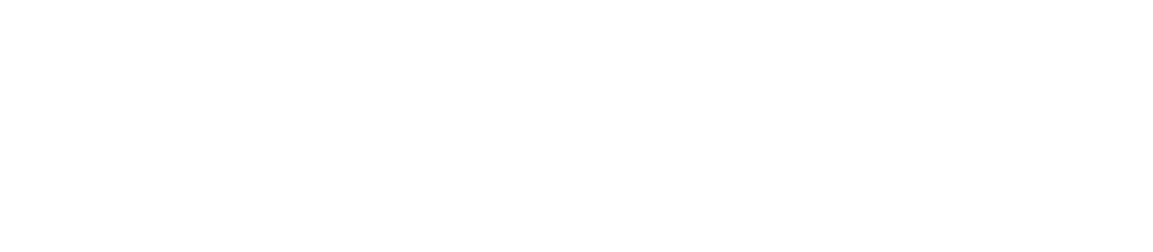


 Location: SET 三立電視台 
 Data Length: 2453 
 Name:  SET 三立電視台
                lat           lng     comments     is_video         likes  \
count  2.453000e+03  2.453000e+03  2453.000000  2453.000000   2453.000000   
mean   2.506185e+01  1.215788e+02     4.234407     0.056258    510.757032   
std    7.675426e-13  1.563513e-12     7.715586     0.230466   2093.084474   
min    2.506185e+01  1.215788e+02     0.000000     0.000000      0.000000   
25%    2.506185e+01  1.215788e+02     0.000000     0.000000     21.000000   
50%    2.506185e+01  1.215788e+02     2.000000     0.000000     51.000000   
75%    2.506185e+01  1.215788e+02     5.000000     0.000000    134.000000   
max    2.506185e+01  1.215788e+02   106.000000     1.000000  36232.000000   

           owner_id        month  
count  2.453000e+03  2453.000000  
mean   8.706973e+08     6.983693  
std    9.453184e+08     3.357404  
min    6.975400e+04     1.000000  
25%    2.370502e+08     5.000000  
50%    4.620825e+08     7.000000  


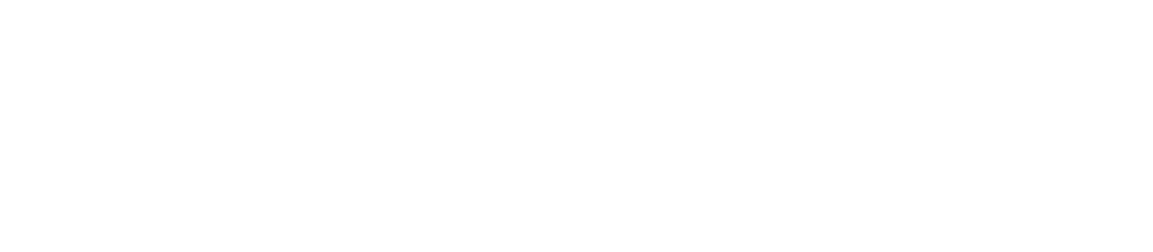


 Location: COFFEE LOVER's PLANET 
 Data Length: 2431 
 Name:  COFFEE LOVER's PLANET
                lat           lng     comments     is_video        likes  \
count  2.431000e+03  2.431000e+03  2431.000000  2431.000000  2431.000000   
mean   2.504050e+01  1.215485e+02     1.689017     0.011929    60.689017   
std    9.487697e-13  3.596086e-12     3.255062     0.108590   212.520030   
min    2.504050e+01  1.215485e+02     0.000000     0.000000     0.000000   
25%    2.504050e+01  1.215485e+02     0.000000     0.000000    10.000000   
50%    2.504050e+01  1.215485e+02     0.000000     0.000000    21.000000   
75%    2.504050e+01  1.215485e+02     2.000000     0.000000    41.000000   
max    2.504050e+01  1.215485e+02    60.000000     1.000000  4892.000000   

           owner_id        month  
count  2.431000e+03  2431.000000  
mean   6.304082e+08     6.831345  
std    8.198462e+08     2.987687  
min    1.102400e+04     1.000000  
25%    3.097272e+07     4.000000  
50%    2.905460e+08 

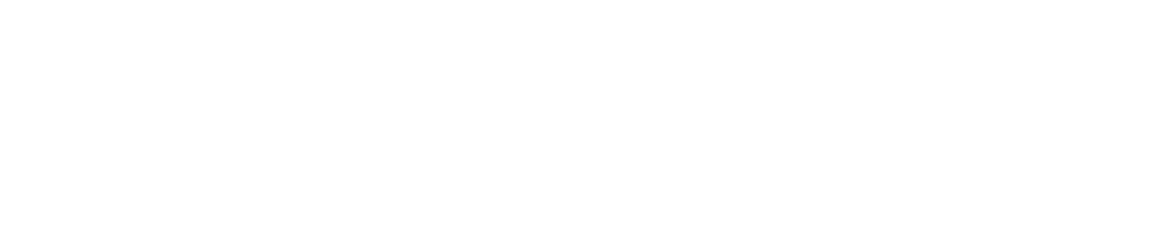


 Location: SWELL CO. CAFE 
 Data Length: 2423 
 Name:  SWELL CO. CAFE
                lat           lng     comments     is_video         likes  \
count  2.423000e+03  2.423000e+03  2423.000000  2423.000000   2423.000000   
mean   2.503563e+01  1.215482e+02     2.773009     0.009492    164.245563   
std    1.041160e-12  1.236600e-12     3.765919     0.096985   1251.905889   
min    2.503563e+01  1.215482e+02     0.000000     0.000000      0.000000   
25%    2.503563e+01  1.215482e+02     0.000000     0.000000     27.000000   
50%    2.503563e+01  1.215482e+02     2.000000     0.000000     53.000000   
75%    2.503563e+01  1.215482e+02     4.000000     0.000000    101.000000   
max    2.503563e+01  1.215482e+02    32.000000     1.000000  36679.000000   

           owner_id        month  
count  2.423000e+03  2423.000000  
mean   6.253769e+08     9.049938  
std    9.185563e+08     1.718044  
min    1.242500e+04     6.000000  
25%    5.208561e+07     8.000000  
50%    2.973627e+08     9

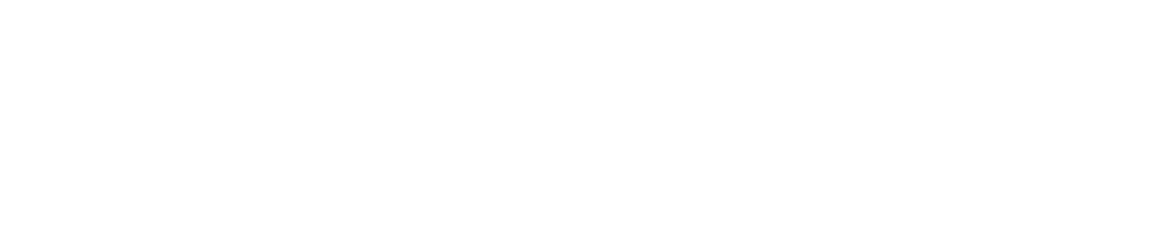


 Location: Daylight光合箱子 南京店 
 Data Length: 2403 
 Name:  Daylight光合箱子 南京店
                lat           lng     comments     is_video         likes  \
count  2.403000e+03  2.403000e+03  2403.000000  2403.000000   2403.000000   
mean   2.505298e+01  1.215470e+02     2.292551     0.009988     63.833125   
std    3.553453e-13  3.610308e-12     3.993716     0.099458    589.491278   
min    2.505298e+01  1.215470e+02     0.000000     0.000000      0.000000   
25%    2.505298e+01  1.215470e+02     0.000000     0.000000     14.000000   
50%    2.505298e+01  1.215470e+02     1.000000     0.000000     26.000000   
75%    2.505298e+01  1.215470e+02     3.000000     0.000000     46.000000   
max    2.505298e+01  1.215470e+02    99.000000     1.000000  25155.000000   

           owner_id        month  
count  2.403000e+03  2403.000000  
mean   7.099610e+08     6.769039  
std    8.811197e+08     3.352756  
min    2.436900e+04     1.000000  
25%    1.804902e+08     4.000000  
50%    3.303312e+08  

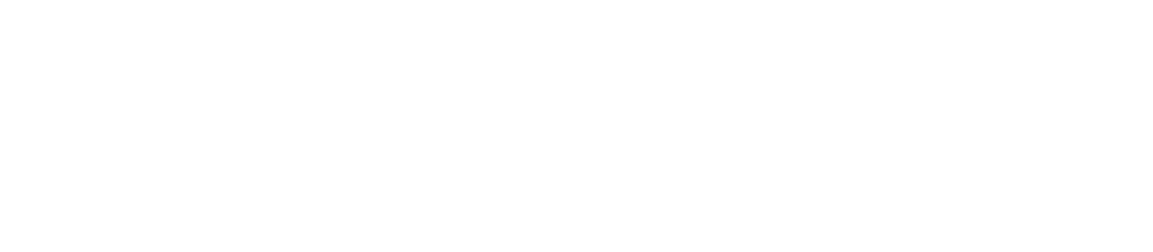


 Location: Remember Me_記得我．Café 
 Data Length: 2403 
 Name:  Remember Me_記得我．Café
                lat           lng     comments     is_video         likes  \
count  2.403000e+03  2.403000e+03  2403.000000  2403.000000   2403.000000   
mean   2.505232e+01  1.215545e+02     2.725759     0.062838     89.185185   
std    9.061305e-13  2.714838e-12     3.553462     0.242722    814.332679   
min    2.505232e+01  1.215545e+02     0.000000     0.000000      0.000000   
25%    2.505232e+01  1.215545e+02     0.000000     0.000000     15.000000   
50%    2.505232e+01  1.215545e+02     2.000000     0.000000     30.000000   
75%    2.505232e+01  1.215545e+02     4.000000     0.000000     59.000000   
max    2.505232e+01  1.215545e+02    62.000000     1.000000  30026.000000   

           owner_id        month  
count  2.403000e+03  2403.000000  
mean   8.502666e+08     6.788598  
std    8.887596e+08     3.535275  
min    5.703700e+04     1.000000  
25%    2.395779e+08     4.000000  
50%    4.2152

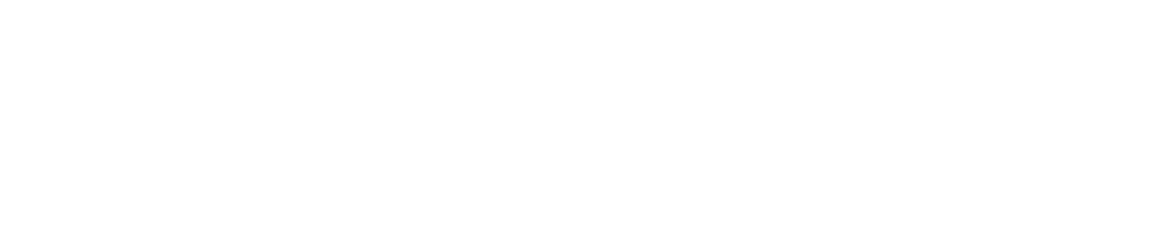


 Location: Drip Cafe 好滴 忠孝店 
 Data Length: 2365 
 Name:  Drip Cafe 好滴 忠孝店
                lat           lng     comments     is_video         likes  \
count  2.365000e+03  2.365000e+03  2365.000000  2365.000000   2365.000000   
mean   2.504095e+01  1.215503e+02     2.763214     0.014799     71.253700   
std    5.330198e-13  5.045920e-12     4.139662     0.120774    381.426771   
min    2.504095e+01  1.215503e+02     0.000000     0.000000      0.000000   
25%    2.504095e+01  1.215503e+02     0.000000     0.000000     17.000000   
50%    2.504095e+01  1.215503e+02     2.000000     0.000000     33.000000   
75%    2.504095e+01  1.215503e+02     4.000000     0.000000     62.000000   
max    2.504095e+01  1.215503e+02    89.000000     1.000000  12377.000000   

           owner_id        month  
count  2.365000e+03  2365.000000  
mean   6.909723e+08     6.746723  
std    7.835055e+08     3.503883  
min    1.384500e+04     1.000000  
25%    2.258662e+08     4.000000  
50%    3.694280e+08  

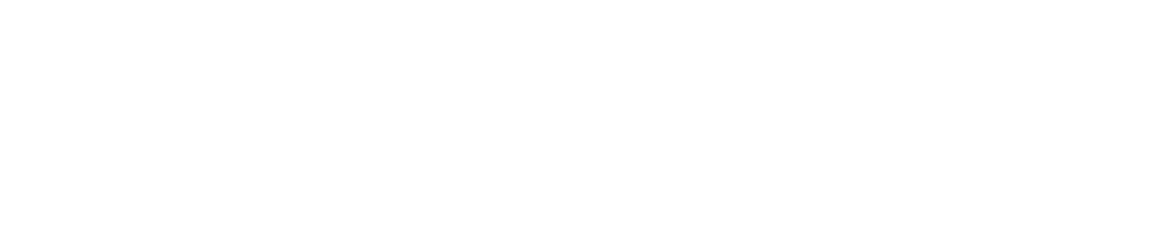


 Location: 孔陵一隻雞 
 Data Length: 2348 
 Name:  孔陵一隻雞
                lat           lng     comments     is_video         likes  \
count  2.348000e+03  2.348000e+03  2348.000000  2348.000000   2348.000000   
mean   2.504091e+01  1.215470e+02     2.912266     0.071124     74.112862   
std    1.350319e-12  1.606169e-12     4.931570     0.257087    465.387904   
min    2.504091e+01  1.215470e+02     0.000000     0.000000      0.000000   
25%    2.504091e+01  1.215470e+02     0.000000     0.000000     12.000000   
50%    2.504091e+01  1.215470e+02     2.000000     0.000000     24.000000   
75%    2.504091e+01  1.215470e+02     4.000000     0.000000     48.000000   
max    2.504091e+01  1.215470e+02   154.000000     1.000000  13336.000000   

           owner_id        month  
count  2.348000e+03  2348.000000  
mean   6.294434e+08     7.422487  
std    7.413561e+08     2.782630  
min    2.690300e+04     2.000000  
25%    2.120399e+08     5.000000  
50%    3.419016e+08     7.000000  
75%    7

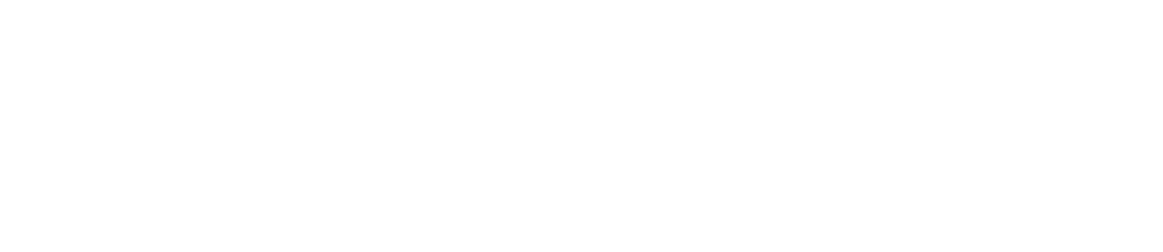


 Location: 牛口水 咖啡·輕食 
 Data Length: 2346 
 Name:  牛口水 咖啡·輕食
                lat           lng     comments     is_video         likes  \
count  2.346000e+03  2.346000e+03  2346.000000  2346.000000   2346.000000   
mean   2.502765e+01  1.215547e+02     2.765985     0.007246    151.699915   
std    1.602615e-12  2.302649e-12     3.679977     0.084835   1229.753064   
min    2.502765e+01  1.215547e+02     0.000000     0.000000      0.000000   
25%    2.502765e+01  1.215547e+02     0.000000     0.000000     30.000000   
50%    2.502765e+01  1.215547e+02     2.000000     0.000000     52.000000   
75%    2.502765e+01  1.215547e+02     4.000000     0.000000     89.000000   
max    2.502765e+01  1.215547e+02    37.000000     1.000000  39010.000000   

           owner_id        month  
count  2.346000e+03  2346.000000  
mean   6.822721e+08    10.107417  
std    8.640782e+08     1.289110  
min    2.324900e+04     8.000000  
25%    2.382183e+08     9.000000  
50%    3.454850e+08    10.000000  


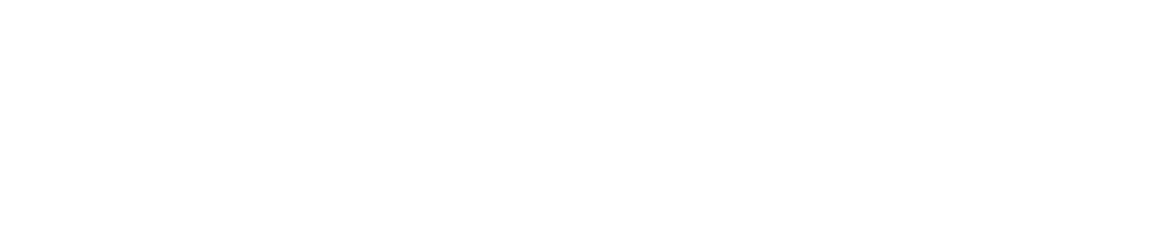


 Location: Le Blanc 
 Data Length: 2335 
 Name:  Le Blanc
                lat           lng     comments     is_video        likes  \
count  2.335000e+03  2.335000e+03  2335.000000  2335.000000  2335.000000   
mean   2.503614e+01  1.215461e+02     2.525054     0.010707    75.382869   
std    1.446264e-12  3.027560e-12     3.974980     0.102940   292.383764   
min    2.503614e+01  1.215461e+02     0.000000     0.000000     0.000000   
25%    2.503614e+01  1.215461e+02     0.000000     0.000000    16.000000   
50%    2.503614e+01  1.215461e+02     1.000000     0.000000    29.000000   
75%    2.503614e+01  1.215461e+02     3.000000     0.000000    54.000000   
max    2.503614e+01  1.215461e+02    64.000000     1.000000  7627.000000   

           owner_id        month  
count  2.335000e+03  2335.000000  
mean   5.688300e+08     7.202570  
std    7.982294e+08     3.228461  
min    4.002600e+04     1.000000  
25%    3.149348e+07     5.000000  
50%    2.661034e+08     7.000000  
75%    6.00

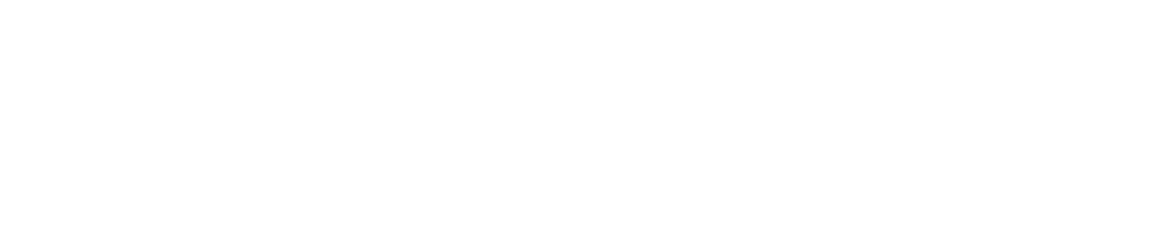


 Location: 錢櫃台北敦南店 
 Data Length: 2306 
 Name:  錢櫃台北敦南店
                lat           lng     comments     is_video        likes  \
count  2.306000e+03  2.306000e+03  2306.000000  2306.000000  2306.000000   
mean   2.504200e+01  1.215493e+02     2.799219     0.145707    83.357762   
std    8.599432e-13  1.989951e-13     3.953528     0.352889   302.864471   
min    2.504200e+01  1.215493e+02     0.000000     0.000000     0.000000   
25%    2.504200e+01  1.215493e+02     0.000000     0.000000    17.000000   
50%    2.504200e+01  1.215493e+02     2.000000     0.000000    34.000000   
75%    2.504200e+01  1.215493e+02     4.000000     0.000000    65.000000   
max    2.504200e+01  1.215493e+02    68.000000     1.000000  5137.000000   

           owner_id        month  
count  2.306000e+03  2306.000000  
mean   5.975985e+08     6.826106  
std    6.797795e+08     3.396519  
min    2.490000e+04     1.000000  
25%    2.081054e+08     4.000000  
50%    3.434952e+08     7.000000  
75%    7.6794

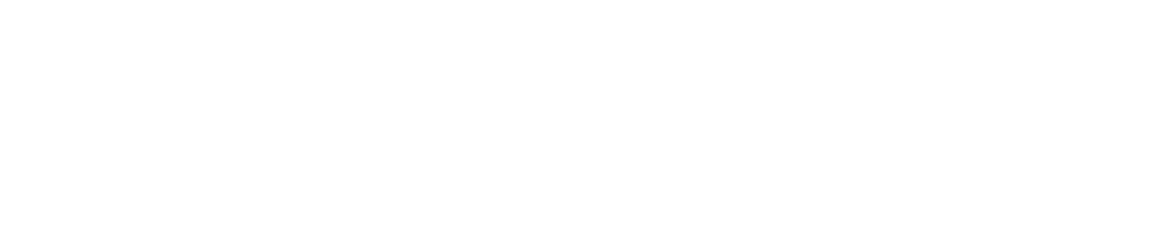


 Location: SOGO 百貨 
 Data Length: 2276 
 Name:  SOGO 百貨
                lat           lng     comments     is_video         likes  \
count  2.276000e+03  2.276000e+03  2276.000000  2276.000000   2276.000000   
mean   2.504183e+01  1.215446e+02     2.240334     0.044376     61.382689   
std    4.050984e-13  4.292621e-12     3.585657     0.205975    374.013753   
min    2.504183e+01  1.215446e+02     0.000000     0.000000      0.000000   
25%    2.504183e+01  1.215446e+02     0.000000     0.000000      9.000000   
50%    2.504183e+01  1.215446e+02     1.000000     0.000000     20.000000   
75%    2.504183e+01  1.215446e+02     3.000000     0.000000     42.000000   
max    2.504183e+01  1.215446e+02    53.000000     1.000000  10345.000000   

           owner_id        month  
count  2.276000e+03  2276.000000  
mean   9.103563e+08     8.017135  
std    1.035686e+09     3.454593  
min    4.303900e+04     1.000000  
25%    1.928304e+08     6.000000  
50%    4.059567e+08     8.000000  
75% 

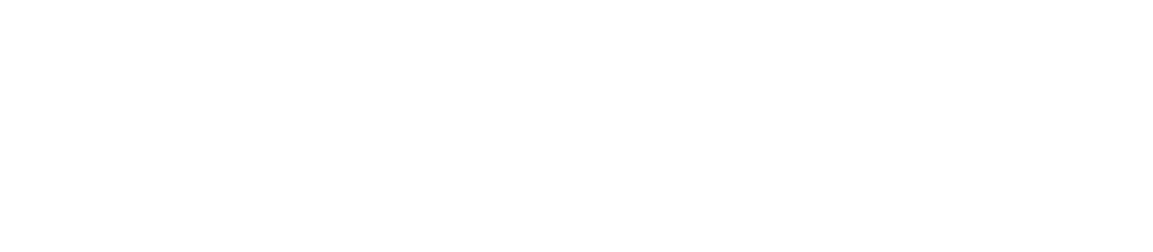


 Location: WOOBar - W Taipei 
 Data Length: 2269 
 Name:  WOOBar - W Taipei
                lat           lng     comments     is_video         likes  \
count  2.269000e+03  2.269000e+03  2269.000000  2269.000000   2269.000000   
mean   2.504084e+01  1.215656e+02     2.327457     0.040546     87.922433   
std    9.807651e-13  3.851991e-12     3.297807     0.197281    394.517305   
min    2.504084e+01  1.215656e+02     0.000000     0.000000      0.000000   
25%    2.504084e+01  1.215656e+02     0.000000     0.000000     14.000000   
50%    2.504084e+01  1.215656e+02     1.000000     0.000000     31.000000   
75%    2.504084e+01  1.215656e+02     3.000000     0.000000     64.000000   
max    2.504084e+01  1.215656e+02    32.000000     1.000000  10620.000000   

           owner_id        month  
count  2.269000e+03  2269.000000  
mean   5.764994e+08     6.900837  
std    7.481836e+08     3.211029  
min    3.802800e+04     1.000000  
25%    4.765982e+07     5.000000  
50%    2.960605e+08

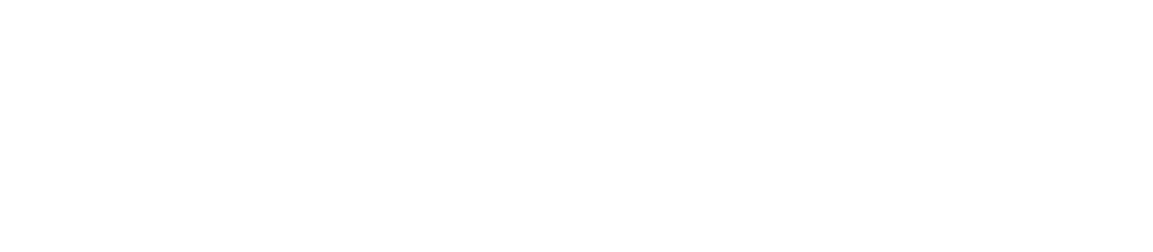


 Location: 瞞著爹 
 Data Length: 2236 
 Name:  瞞著爹
                lat           lng     comments     is_video        likes  \
count  2.236000e+03  2.236000e+03  2236.000000  2236.000000  2236.000000   
mean   2.504794e+01  1.215453e+02     2.551878     0.011181    61.341234   
std    1.161997e-12  7.107017e-13     4.081331     0.105169   218.412747   
min    2.504794e+01  1.215453e+02     0.000000     0.000000     0.000000   
25%    2.504794e+01  1.215453e+02     0.000000     0.000000    15.000000   
50%    2.504794e+01  1.215453e+02     1.000000     0.000000    30.000000   
75%    2.504794e+01  1.215453e+02     3.000000     0.000000    54.000000   
max    2.504794e+01  1.215453e+02    74.000000     1.000000  6104.000000   

           owner_id        month  
count  2.236000e+03  2236.000000  
mean   5.327303e+08     5.783095  
std    7.760709e+08     3.333096  
min    3.657000e+03     1.000000  
25%    3.053200e+07     3.000000  
50%    2.636466e+08     5.000000  
75%    5.297690e+08  

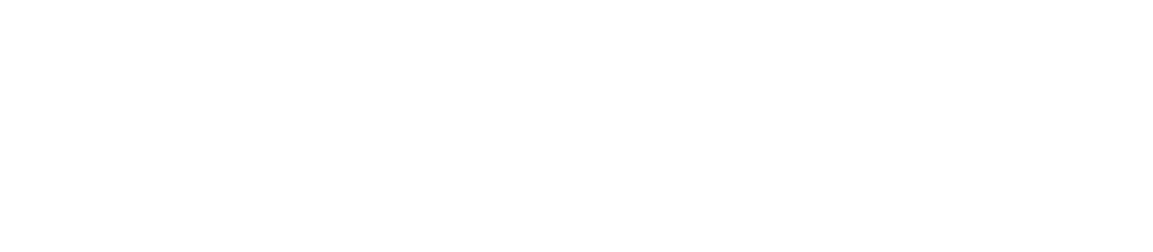


 Location: Pocha 韓式熱炒 포차 
 Data Length: 2229 
 Name:  Pocha 韓式熱炒 포차
                lat           lng     comments     is_video        likes  \
count  2.229000e+03  2.229000e+03  2229.000000  2229.000000  2229.000000   
mean   2.504043e+01  1.215535e+02     2.873037     0.112158    50.926424   
std    5.223661e-13  1.748327e-12     3.883346     0.315631   105.749666   
min    2.504043e+01  1.215535e+02     0.000000     0.000000     0.000000   
25%    2.504043e+01  1.215535e+02     0.000000     0.000000    17.000000   
50%    2.504043e+01  1.215535e+02     2.000000     0.000000    32.000000   
75%    2.504043e+01  1.215535e+02     4.000000     0.000000    59.000000   
max    2.504043e+01  1.215535e+02    48.000000     1.000000  3214.000000   

           owner_id        month  
count  2.229000e+03  2229.000000  
mean   6.325004e+08     6.646478  
std    7.081805e+08     3.318480  
min    1.810700e+04     1.000000  
25%    2.336740e+08     4.000000  
50%    3.562616e+08     7.000000  
7

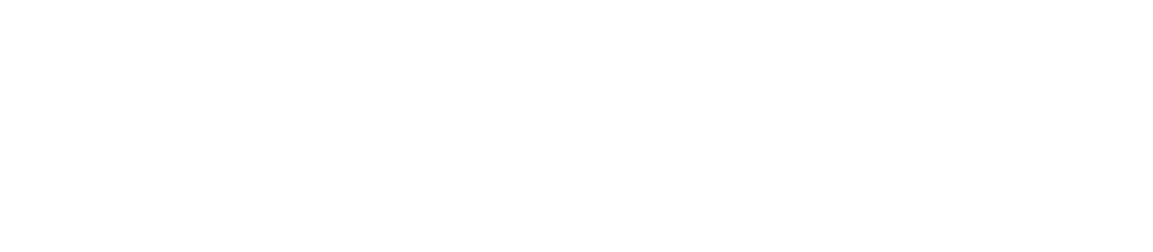


 Location: 九州鬆餅咖啡 - 台北富錦店 / 九州パンケーキカフェ 
 Data Length: 2224 
 Name:  九州鬆餅咖啡 - 台北富錦店 / 九州パンケーキカフェ
                lat           lng     comments     is_video         likes  \
count  2.224000e+03  2.224000e+03  2224.000000  2224.000000   2224.000000   
mean   2.506086e+01  1.215608e+02     2.285072     0.008543     74.586331   
std    5.934366e-13  3.439800e-12     3.544160     0.092054    894.241190   
min    2.506086e+01  1.215608e+02     0.000000     0.000000      0.000000   
25%    2.506086e+01  1.215608e+02     0.000000     0.000000     12.000000   
50%    2.506086e+01  1.215608e+02     1.000000     0.000000     23.000000   
75%    2.506086e+01  1.215608e+02     3.000000     0.000000     45.000000   
max    2.506086e+01  1.215608e+02    37.000000     1.000000  39582.000000   

           owner_id        month  
count  2.224000e+03  2224.000000  
mean   7.342854e+08     6.047662  
std    8.421695e+08     3.501747  
min    1.384500e+04     1.000000  
25%    1.925902e+08     3.000000  

FileNotFoundError: [Errno 2] No such file or directory: './plot/九州鬆餅咖啡 - 台北富錦店 / 九州パンケーキカフェ.png'

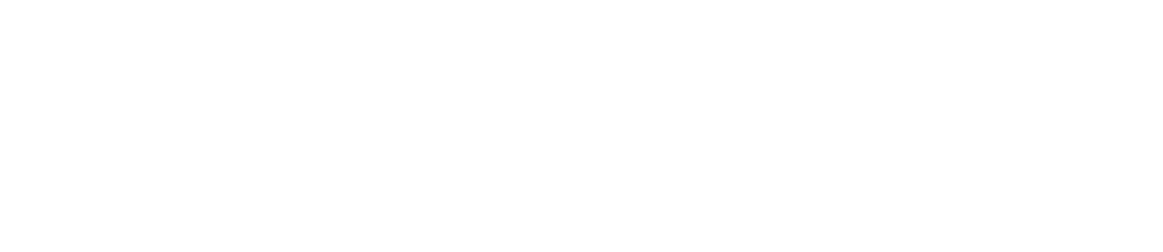

In [140]:
loc_ranking = (ig2016
    .location_name
    .value_counts())[:100]
for each in loc_ranking.index:
    get_loc_plot(each, ig2016, each)